In [2]:
import uproot
import sys
import glob
import os
import struct
import time
import csv
import pickle
import math
import gc

import numpy                  as np
import pandas                 as pd
import matplotlib             as mpl
import matplotlib.pyplot      as plt
import tensorflow             as tf
from   tensorflow             import keras

import scipy
from   scipy             import interpolate
from   scipy.interpolate import CubicSpline, splev, splrep, PPoly
from   scipy.optimize    import curve_fit, minimize

# from   scipy.stats            import kde
# from   mpl_toolkits           import mplot3d
# from   mpl_toolkits.mplot3d   import Axes3D

# sys.path.insert(0, "/home/chan/2_ROOT/0_FROST/0_FROSTpython")
# from   rbDST2dict import rbDST2dict_chan as frz
# from   rbDST2dict.rbDST2dict_chan import rbDST2dict_chan as frz
# from   rbDST2dict             import rbDST2dict_chan as frz      #rbDST2dict=dir, rbDST2dict.py=module, rbDST2dict()=class
                                                                 #you need to specify the folder -> "from rbDST2dict"

#To increase the cell width + load Images
from IPython.core.display import display, HTML, Image
# display(HTML("<style>.container { width:100% !important; }</style
#Pandas options
pd.options.display.max_columns = None
# pd.options.display.max_rows    = 100

#Plotting Config
mpl.style.use("default")
mpl.rcParams["axes.facecolor"] = "#EAEAF2" 
mpl.rcParams['figure.dpi']     = 100 
mpl.rcParams['savefig.dpi']    = 100 

# Preprocess 

### Checking SKIMMED files

In [ ]:
# rootFile          = uproot.open("~/Desktop/data/frost_data/eloss/test_photon.root")
rootFile = uproot.open("~/Desktop/data/frost_data/eloss/epho1.6_1/cooked_055521.root")
rootFile_bankTree = rootFile["finTree;1"]
print(rootFile_bankTree.keys())
print(rootFile_bankTree.show())

In [5]:
#Reduce memory usage by changing dtype
def reduce_mem_usage(df):

    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
        #    df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [6]:
# #Skim File Check
# rootFile_list = []
# df_GMSH       = pd.DataFrame()  
# counter_file  = 0

# rootFile_list.append(uproot.open("/home/chan/Desktop/data/frost_data/eloss/epho1.6_1/cooked_055521.root"))

    
# for i in rootFile_list:
#     #Read Tree
#     tree = i["finTree;1"]
    
#     #Show status
#     print(counter_file)
#     counter_file += 1
    
#     #dataframe
#     df_GMSH_1           = pd.DataFrame()
    
#     #Adding columns
#     df_GMSH_1["pid"]        = pd.Series(tree.array("pid"), dtype=object)
#     df_GMSH_1["E"]          = pd.Series(tree.array("E"))
#     df_GMSH_1["px"]         = pd.Series(tree.array("px"))
#     df_GMSH_1["py"]         = pd.Series(tree.array("py"))
#     df_GMSH_1["pz"]         = pd.Series(tree.array("pz"))
#     df_GMSH_1["betac"]       = pd.Series(tree.array("betac"))
#     df_GMSH_1["mass"]       = pd.Series(tree.array("mass"))
#     df_GMSH_1["betam"]      = pd.Series(tree.array("betam"))
#     df_GMSH_1["epho"]       = pd.Series(tree.array("epho"))
#     #df_GMSH_1["ntrk"]       = pd.Series(tree.array("ntrk"))
#     df_GMSH_1["x"]          = pd.Series(tree.array("x"))
#     df_GMSH_1["y"]          = pd.Series(tree.array("y"))
#     df_GMSH_1["z"]          = pd.Series(tree.array("z"))
#     df_GMSH_1["scPdHt"]     = pd.Series(tree.array("scpdht"), dtype=object)
#     df_GMSH_1["TRIGBITS"]   = pd.Series(tree.array("trigbits"), dtype=object)
#     df_GMSH_1["el_px"]      = pd.Series(tree.array("elossPX"))
#     df_GMSH_1["el_py"]      = pd.Series(tree.array("elossPY"))
#     df_GMSH_1["el_pz"]      = pd.Series(tree.array("elossPZ"))
#     df_GMSH_1["el_E"]       = pd.Series(tree.array("elossE"))
    
#     df_GMSH_1["tpho"]                = pd.Series(tree.array("tpho"))
#     df_GMSH_1["timediff"]            = pd.Series(tree.array("timediff"))
#     #df_GMSH_1["tpro"]       = pd.Series(tree.array("tpro"))
#     #df_GMSH_1["lpro"]       = pd.Series(tree.array("lpro"))

    
    
#     #Run Number colume
#     df_GMSH_1["runNum"]     = int(str(i.name)[12] + str(i.name)[13] + str(i.name)[14] + str(i.name)[15] + str(i.name)[16]) 
    
#     #Drop rows "not-available" data
#     df_GMSH_1.dropna(inplace=True)
    
#     #Remove epho~0 events
#     df_GMSH_1 = df_GMSH_1[df_GMSH_1["epho"] > 0.01]
    
#     #Select only protons
#     df_GMSH_1 = df_GMSH_1[df_GMSH_1["pid"] == 14]
    
#     #Reduce memory usage by chaning dtype
#     df_GMSH_1 = reduce_mem_usage(df_GMSH_1)
    
#     #Append df_GMSH_1 from each .root file to total df_GMSH
#     df_GMSH   = df_GMSH.append(df_GMSH_1, ignore_index=True)

# #Reset index
# df_GMSH = df_GMSH.reset_index(drop=True)

### Read Data 

In [12]:
#Reduce memory usage by changing dtype
def reduce_mem_usage(df):

    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
        #    df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [ ]:
# Low Energy - Run periods 1, 2, 3

# path          = "/home/chan/Desktop/data/frost_data/eloss/epho1.6_1"
# path          = "/home/chan/Desktop/data/frost_data/eloss/epho1.6_2"
# path          = "/home/chan/Desktop/data/frost_data/eloss/epho1.6_3"

files         =  glob.glob(path + "/*.root")
# files.extend(glob.glob(path_2 + "/*.root"))
# files.extend(glob.glob(path_3 + "/*.root"))

rootFile_list = []
df_GMSH       = pd.DataFrame()  
counter_file  = 0

for f in files:
    rootFile_list.append(uproot.open(f))
    
for i in rootFile_list:
    #Read Tree
    tree = i["finTree;1"]
    
    #Show status
    print(counter_file)
    counter_file += 1
    
    #dataframe
    df_GMSH_1           = pd.DataFrame()
    
    #Adding columns
    df_GMSH_1["pid"]        = pd.Series(tree.array("pid"), dtype=object)
    df_GMSH_1["E"]          = pd.Series(tree.array("E"))
    df_GMSH_1["px"]         = pd.Series(tree.array("px"))
    df_GMSH_1["py"]         = pd.Series(tree.array("py"))
    df_GMSH_1["pz"]         = pd.Series(tree.array("pz"))
    df_GMSH_1["betac"]       = pd.Series(tree.array("betac"))
    df_GMSH_1["mass"]       = pd.Series(tree.array("mass"))
    df_GMSH_1["betam"]      = pd.Series(tree.array("betam"))
    df_GMSH_1["epho"]       = pd.Series(tree.array("epho"))
    #df_GMSH_1["ntrk"]       = pd.Series(tree.array("ntrk"))
    df_GMSH_1["x"]          = pd.Series(tree.array("x"))
    df_GMSH_1["y"]          = pd.Series(tree.array("y"))
    df_GMSH_1["z"]          = pd.Series(tree.array("z"))
    df_GMSH_1["scPdHt"]     = pd.Series(tree.array("scpdht"), dtype=object)
    df_GMSH_1["TRIGBITS"]   = pd.Series(tree.array("trigbits"), dtype=object)
    df_GMSH_1["el_px"]      = pd.Series(tree.array("elossPX"))
    df_GMSH_1["el_py"]      = pd.Series(tree.array("elossPY"))
    df_GMSH_1["el_pz"]      = pd.Series(tree.array("elossPZ"))
    df_GMSH_1["el_E"]       = pd.Series(tree.array("elossE"))
    df_GMSH_1["timediff"]   = pd.Series(tree.array("timediff"))
    
    #Run Number colume
    df_GMSH_1["runNum"]     = int(str(i.name)[12] + str(i.name)[13] + str(i.name)[14] + str(i.name)[15] + str(i.name)[16]) 
    
    #Drop rows "not-available" data
    df_GMSH_1.dropna(inplace=True)
    
    #Remove epho~0 events
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["epho"] > 0.01]
    
    #Select only protons - Only use this when the dataset is too large. Trusting GPID pid is bad.
    #    -Use beta diff vs p selection to select protons
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["pid"] != 8]
    
    #Reduce memory usage by chaning dtype
    df_GMSH_1 = reduce_mem_usage(df_GMSH_1)
    
    #Append df_GMSH_1 from each .root file to total df_GMSH
    df_GMSH   = df_GMSH.append(df_GMSH_1, ignore_index=True)

#Reset index
df_GMSH = df_GMSH.reset_index(drop=True)

In [ ]:
#Low Energy - Run periods 4, 5, 6, 7

# path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_1"
# path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_2"
# path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_3"
path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_4"

files         =  glob.glob(path + "/*.root")
# files.extend(glob.glob(path_2 + "/*.root"))
# files.extend(glob.glob(path_3 + "/*.root"))

rootFile_list = []
df_GMSH       = pd.DataFrame()  
counter_file  = 0

for f in files:
    rootFile_list.append(uproot.open(f))
    
for i in rootFile_list:
    #Read Tree
    tree = i["finTree;1"]
    
    #Show status
    print(counter_file)
    counter_file += 1
    
    #dataframe
    df_GMSH_1           = pd.DataFrame()
    
    #Adding columns
    df_GMSH_1["pid"]        = pd.Series(tree.array("pid"), dtype=object)
    df_GMSH_1["E"]          = pd.Series(tree.array("E"))
    df_GMSH_1["px"]         = pd.Series(tree.array("px"))
    df_GMSH_1["py"]         = pd.Series(tree.array("py"))
    df_GMSH_1["pz"]         = pd.Series(tree.array("pz"))
    df_GMSH_1["betac"]       = pd.Series(tree.array("betac"))
    df_GMSH_1["mass"]       = pd.Series(tree.array("mass"))
    df_GMSH_1["betam"]      = pd.Series(tree.array("betam"))
    df_GMSH_1["epho"]       = pd.Series(tree.array("epho"))
    #df_GMSH_1["ntrk"]       = pd.Series(tree.array("ntrk"))
    df_GMSH_1["x"]          = pd.Series(tree.array("x"))
    df_GMSH_1["y"]          = pd.Series(tree.array("y"))
    df_GMSH_1["z"]          = pd.Series(tree.array("z"))
    df_GMSH_1["scPdHt"]     = pd.Series(tree.array("scpdht"), dtype=object)
    df_GMSH_1["TRIGBITS"]   = pd.Series(tree.array("trigbits"), dtype=object)
    df_GMSH_1["el_px"]      = pd.Series(tree.array("elossPX"))
    df_GMSH_1["el_py"]      = pd.Series(tree.array("elossPY"))
    df_GMSH_1["el_pz"]      = pd.Series(tree.array("elossPZ"))
    df_GMSH_1["el_E"]       = pd.Series(tree.array("elossE"))
    df_GMSH_1["timediff"]   = pd.Series(tree.array("timediff"))
    
    #Run Number colume
    df_GMSH_1["runNum"]     = int(str(i.name)[12] + str(i.name)[13] + str(i.name)[14] + str(i.name)[15] + str(i.name)[16]) 
    
    #Drop rows "not-available" data
    df_GMSH_1.dropna(inplace=True)
    
    #Remove epho~0 events
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["epho"] > 0.01]
    
    #RUN PERIOD 4, 5, 6, 7 - LOW ENERGY SELECTION
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["epho"] <= 1.6]
    
    #Select only protons - Only use this when the dataset is too large. Trusting GPID pid is bad.
    #    -Use beta diff vs p selection to select protons
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["pid"] != 8]
    
    #Reduce memory usage by chaning dtype
    df_GMSH_1 = reduce_mem_usage(df_GMSH_1)
    
    #Append df_GMSH_1 from each .root file to total df_GMSH
    df_GMSH   = df_GMSH.append(df_GMSH_1, ignore_index=True)

#Reset index
df_GMSH = df_GMSH.reset_index(drop=True)

In [ ]:
#High Energy - Run periods 4, 5, 6, 7

# path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_1"
# path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_2"
# path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_3"
path          = "/home/chan/Desktop/data/frost_data/eloss/epho2.4_4"

files         =  glob.glob(path + "/*.root")
# files.extend(glob.glob(path_2 + "/*.root"))
# files.extend(glob.glob(path_3 + "/*.root"))

rootFile_list = []
df_GMSH       = pd.DataFrame()  
counter_file  = 0

for f in files:
    rootFile_list.append(uproot.open(f))
    
for i in rootFile_list:
    #Read Tree
    tree = i["finTree;1"]
    
    #Show status
    print(counter_file)
    counter_file += 1
    
    #dataframe
    df_GMSH_1           = pd.DataFrame()
    
    #Adding columns
    df_GMSH_1["pid"]        = pd.Series(tree.array("pid"), dtype=object)
    df_GMSH_1["E"]          = pd.Series(tree.array("E"))
    df_GMSH_1["px"]         = pd.Series(tree.array("px"))
    df_GMSH_1["py"]         = pd.Series(tree.array("py"))
    df_GMSH_1["pz"]         = pd.Series(tree.array("pz"))
    df_GMSH_1["betac"]       = pd.Series(tree.array("betac"))
    df_GMSH_1["mass"]       = pd.Series(tree.array("mass"))
    df_GMSH_1["betam"]      = pd.Series(tree.array("betam"))
    df_GMSH_1["epho"]       = pd.Series(tree.array("epho"))
    #df_GMSH_1["ntrk"]       = pd.Series(tree.array("ntrk"))
    df_GMSH_1["x"]          = pd.Series(tree.array("x"))
    df_GMSH_1["y"]          = pd.Series(tree.array("y"))
    df_GMSH_1["z"]          = pd.Series(tree.array("z"))
    df_GMSH_1["scPdHt"]     = pd.Series(tree.array("scpdht"), dtype=object)
    df_GMSH_1["TRIGBITS"]   = pd.Series(tree.array("trigbits"), dtype=object)
    df_GMSH_1["el_px"]      = pd.Series(tree.array("elossPX"))
    df_GMSH_1["el_py"]      = pd.Series(tree.array("elossPY"))
    df_GMSH_1["el_pz"]      = pd.Series(tree.array("elossPZ"))
    df_GMSH_1["el_E"]       = pd.Series(tree.array("elossE"))
    df_GMSH_1["timediff"]   = pd.Series(tree.array("timediff"))
    
    #Run Number colume
    df_GMSH_1["runNum"]     = int(str(i.name)[12] + str(i.name)[13] + str(i.name)[14] + str(i.name)[15] + str(i.name)[16]) 
    
    #Drop rows "not-available" data
    df_GMSH_1.dropna(inplace=True)
    
    #Remove epho~0 events
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["epho"] > 0.01]
    
    #RUN PERIOD 4, 5, 6, 7 - HIGH ENERGY SELECTION
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["epho"] > 1.6]
    
    #Select only protons - Only use this when the dataset is too large. Trusting GPID pid is bad.
    #    -Use beta diff vs p selection to select protons
    df_GMSH_1 = df_GMSH_1[df_GMSH_1["pid"] != 8]
    
    #Reduce memory usage by chaning dtype
    df_GMSH_1 = reduce_mem_usage(df_GMSH_1)
    
    #Append df_GMSH_1 from each .root file to total df_GMSH
    df_GMSH   = df_GMSH.append(df_GMSH_1, ignore_index=True)

#Reset index
df_GMSH = df_GMSH.reset_index(drop=True)

### Preprocess 1 - ELOSS

#### Compute $|p|$  

In [95]:
#Optimized Version - np.vectorize()
def comp_pabs(px, py, pz):
    p_abs = math.sqrt(pow(px, 2) + pow(py, 2) + pow(pz, 2))
    return p_abs

#Vectorize
vect_comp_pabs = np.vectorize(comp_pabs, otypes=[np.float])
p_abs          = vect_comp_pabs(df_GMSH["px"].values, df_GMSH["py"].values, df_GMSH["pz"].values)

#Append to df
df_GMSH["p_abs"] = pd.Series(p_abs, index=df_GMSH.index)

#### Compute eloss $|p|$  

In [96]:
#Optimized Version - np.vectorize()
def comp_pabs(px, py, pz):
    p_abs = math.sqrt(pow(px, 2) + pow(py, 2) + pow(pz, 2))
    return p_abs

#Vectorize
vect_comp_pabs = np.vectorize(comp_pabs, otypes=[np.float])
p_abs          = vect_comp_pabs(df_GMSH["el_px"].values, df_GMSH["el_py"].values, df_GMSH["el_pz"].values)

#Append to df
df_GMSH["el_p_abs"] = pd.Series(p_abs, index=df_GMSH.index)

#### Compute Missing Mass Squred of $\pi_0$  

In [97]:
#Optimized Version - np.vectorize()
def comp_mmsq(epho, E, m1, p_abs, pz):
    mmsq = pow(E, 2) - 2*epho*E + pow(m1,2) + 2*epho*m1 - 2*m1*E - pow(p_abs, 2) + 2*epho*pz
    return mmsq

#Vectorize
vect_comp_mmsp = np.vectorize(comp_mmsq, otypes=[np.float])
mmsq_pi0       = vect_comp_mmsp(df_GMSH["epho"].values, df_GMSH["E"].values, 0.93827, \
                                df_GMSH["p_abs"].values, df_GMSH["pz"].values)

#Append to df
df_GMSH["mmsq_pi0"] = pd.Series(mmsq_pi0, index=df_GMSH.index)

#### Compute ELOSS Missing Mass Squred of $\pi_0$  

In [98]:
#Optimized Version - np.vectorize()
def comp_mmsq(epho, E, m1, p_abs, pz):
    mmsq = pow(E, 2) - 2*epho*E + pow(m1,2) + 2*epho*m1 - 2*m1*E - pow(p_abs, 2) + 2*epho*pz
    return mmsq

#Vectorize
vect_comp_mmsp = np.vectorize(comp_mmsq, otypes=[np.float])
mmsq_pi0       = vect_comp_mmsp(df_GMSH["epho"].values, df_GMSH["el_E"].values, 0.93827, \
                                df_GMSH["el_p_abs"].values, df_GMSH["el_pz"].values)

#Append to df
df_GMSH["el_mmsq_pi0"] = pd.Series(mmsq_pi0, index=df_GMSH.index)

#### Compute angles of trajectory 

In [99]:
#Optimized Version - np.vectorize()
def comp_theta(pz, p_abs):
    if (p_abs == 0.0):
        theta = 0
    else:
        theta = abs(math.degrees(math.acos(pz / p_abs)))
    return theta

def comp_phi(px, py):
    phi = math.degrees(math.atan2(py , px))
    return phi
    
#Vectorize
vect_comp_theta = np.vectorize(comp_theta, otypes=[np.float])
vect_comp_phi   = np.vectorize(comp_phi, otypes=[np.float])

#Compute
theta           = vect_comp_theta(df_GMSH["pz"].values, df_GMSH["p_abs"].values) 
phi             = vect_comp_phi(df_GMSH["px"].values, df_GMSH["py"].values)

#Append
df_GMSH["theta"] = pd.Series(theta, index=df_GMSH.index)
df_GMSH["phi"]   = pd.Series(phi, index=df_GMSH.index)

#### Compute Sector + tof paddle

In [100]:
#Optimized Version - np.vectorize()
def comp_sect(scpdht):
    sect = int(str(scpdht)[0])
    return sect

def comp_tof_pad(scpdht):
    try:
        tof_pad = int(str(scpdht)[1] + str(scpdht)[2])
    except IndexError:
        #100 to indicate wrong
        tof_pad = 100
    return tof_pad
    
#Vectorize
vect_comp_sect      = np.vectorize(comp_sect, otypes=[np.int])
vect_comp_tof_pad   = np.vectorize(comp_tof_pad, otypes=[np.int])

#Compute
sect                = vect_comp_sect(df_GMSH["scPdHt"].values)
tof_pad             = vect_comp_tof_pad(df_GMSH["scPdHt"].values)

#Append
df_GMSH["sector"]    = pd.Series(sect, index=df_GMSH.index)
df_GMSH["tof_pad"]   = pd.Series(tof_pad, index=df_GMSH.index)

#### Compute $\Delta \beta = \beta_{meas} - \beta_{comp}$ 

In [101]:
#Optimized Version - np.vectorize()
def comp_beta_diff(betam, beta):
    beta_diff = betam - beta
    return beta_diff

#Vectorize
vect_comp_beta_diff = np.vectorize(comp_beta_diff, otypes=[np.float])
beta_diff           = vect_comp_beta_diff(df_GMSH["betam"].values, df_GMSH["betac"].values)

#Append to df
df_GMSH["beta_diff"] = pd.Series(beta_diff, index=df_GMSH.index)

### Preprocess 3 - Momentum Correction

###### Notes 

In [ ]:
# * Energy Loss Correction [Eugene] (NOTES)
#     * Accounts for energy losses in the target material, target wall, carbon cylinder, and start counter

# * Momentum Correction [Steffen Analysis Note 2014_101]
#     * Disft Chamber misalignments and megnetic field-map uncertainties.
#     * $\Delta p = p(\theta) - p \neq 0$
#     * p is `measured` momentum from tracking, which is the magnitude of momentum
#     * $p(\theta)$ is computed momentum by using px, py, pz, that is using $\theta$ and $\phi$.
#     * from [Steffen AN2014-101 Fig14], we can see that measured momentum magnitude is different from the momentum magnitude
#       computed by using angle and phi.
#     * If we assume $\theta$ is measured correctly, this shows the error in $\phi$ measurements.

In [ ]:
# * Phi_Sector = Redefined phi according to sector location (NOTES)
#     * Sector 1 - 3:
#         * phi_sec = phi - 60*(sector-1)
#     * Sector 4:
#         * if (phi >= 150 and phi <= 180):
#             * phi_sec = phi - 180
#         * if (phi >= -180 and phi <= -150):
#             * phi_sec = phi + 180
#     * Sector 5:
#         * phi_sec = phi + 120
#     * Sector 6:
#         * phi_sec = phi + 160

In [ ]:
# Image(filename="phi_sector.jpg")

#### Need for Momentum Correction (CHECK) 

In [5]:
# #Define wanted columns
# all_cols      = list(df_GMSH.columns)
# wanted_cols   = ["theta", "phi", "phi_sec", "sector", "el_p_abs"] 
# unwanted_cols = [i for i in all_cols if (i not in wanted_cols)]

In [6]:
# #Drop unwanted columns
# df_GMSH.drop(columns=unwanted_cols, inplace=True)

In [78]:
# #Compute and append momentum difference between measured p and calculated p using theta and phi
# def comp_p_diff_abs(el_p_abs, theta, phi):

# #     el_p_abs = el_p_abs.astype("float64")
# #     theta    = theta.astype("float64")
# #     phi      = phi.astype("float64")
    
#     #Difference of measured momentum from drift chamber to the calculated momentum using measured momentum from dc, theta, phi
# #     p_diff_abs = np.sqrt(pow(el_p_abs, 2)*(pow(np.cos(np.deg2rad(phi)), 2) * pow(np.sin(np.deg2rad(theta)), 2) + 
# #                                            pow(np.sin(np.deg2rad(phi)), 2) * pow(np.sin(np.deg2rad(theta)), 2) +
# #                                            pow(np.cos(np.deg2rad(theta)), 2))) - el_p_abs
    
#     p_diff_abs = np.sqrt(pow(el_p_abs, 2)*(pow(np.cos(np.deg2rad(phi)), 2) * pow(np.sin(np.deg2rad(theta)), 2) + 
#                                        pow(np.sin(np.deg2rad(phi)), 2) * pow(np.sin(np.deg2rad(theta)), 2) +
#                                        pow(np.cos(np.deg2rad(theta)), 2)))

# #     p_diff_abs = pow(el_p_abs, 2)*(pow(np.cos(np.deg2rad(phi)), 2) * pow(np.sin(np.deg2rad(theta)), 2) + 
# #                                            pow(np.sin(np.deg2rad(phi)), 2) * pow(np.sin(np.deg2rad(theta)), 2) +
# #                                            pow(np.cos(np.deg2rad(theta)), 2)) - el_p_abs
    
    
    
#     return p_diff_abs

# #Vectorize
# vect_comp_p_diff_abs  = np.vectorize(comp_p_diff_abs, otypes=[np.float16])

# #Compute
# p_diff_abs            = vect_comp_p_diff_abs(df_GMSH["el_p_abs"].values, df_GMSH["theta"].values, df_GMSH["phi"].values)

# #Append
# df_GMSH["p_diff_abs"] = pd.Series(p_diff_abs, index=df_GMSH.index)

#### Compute pCorr Coefficient (LATER)

#### Steffen's p-Corr Coefficients 

In [102]:
#Coefficients of fittingp polynomials [Steffen AN2014-101 pg15 eq26]
p_corr_1 = [-30.7504,97.5948,71.7915,1.6913,28.998,
            -220.329,-41.3553,106.466,319.99,536.242,-1257.09,-2821.91,-69.3222,
            -603.08,5177.62,636.92,-1414.77,-7397.37,-3005.01,2823.63,33820.2,
            709.582,2576.88,-38471.1,-3392.37,3688.73,64773.7,7174.1,11537,-159537,
            -3044.72,-3549.85,118816,8046.17,6562.15,-257214,-6742.38,-52102,
            325898,5769.74,-1556.82,-168198,-8141.57,-39162.2,472255,1494.09,
            50221.8,-234572,-3718.2,2549.17,95409.3,2033.44,44574.5,-333960]
p_corr_2 = [2.19944,-32.5312,61.9317,-1.62315,
            -12.3236,-27.5163,-26.7907,57.2353,-42.7167,19.2973,270.637,-983.954,
            56.4156,-54.9767,1485,270.939,0.324475,-64.0535,-240.804,-1710.7,
            6361.39,-375.292,-75.7447,-14450.5,-905.319,-3694.98,383.702,972.038,
            4082.85,-11865.5,733.937,3118.62,48353.8,1508.7,11054.4,15510.2,
            -1663.24,-3045.1,62.6145,176.116,-13978.3,-62220.2,-1680.36,-7223.88,
            -56065.5,1087.02,-751.4,13041.4,-999.976,15129.4,24108.5,963.352,
            -1877.56,47389.5]
p_corr_3 = [-18.1,43.0589,83.8415,-5.89401,
            -6.55493,-104.7,-52.1528,226.588,-77.6407,353.28,-808.474,-2263.23,
            128.063,-37.9396,1471.57,880.922,-3178.34,-1394.48,-2052.52,1557.56,
            25588.7,-960.965,276.65,-7875.79,-5083.75,10894.8,39929.9,4959.14,
            10310.5,-117983,2370.47,6793.33,-12796.9,11857.1,13324.8,-269795,
            -4920.47,-39400,233757,-233.204,-46288.7,145907,-7837.41,-129682,
            722885,1522.9,34741,-163737,-3292.27,64313.4,-203098,-3743.94,
            163073,-660311]
p_corr_4 = [-14.7419,58.6922,82.2727,-3.1439,
            -48.5351,35.9019,-50.2487,241.727,-170.195,289.405,-388.423,-2906.6,
            82.6128,712.304,-1570.96,684.632,-3176.52,1024.73,-1706.01,-1135.17,
            27308,-766.532,-3875.79,15801.6,-3106.66,10823.1,13438.6,4633.29,
            11808.8,-103447,3012.51,9988.08,-79345.8,4815.81,3167.32,-121415,
            -6149.95,-24336.1,172274,-4598.2,-20608.7,181333,322.742,-63320.1,
            304915,3244.64,15053.6,-101195,2241.28,19232.7,-144122,-3597.04,
            61861.7,-225342]
p_corr_5 = [-28.8231,88.2423,113.423,4.6255,
            -30.4208,-68.2225,-42.1898,336.317,-376.41,500.01,-741.312,-4451.79,
            -102.144,538.809,1697.55,653.463,-5185.05,4917.81,-2863.31,321.197,
            37146.6,653.256,-2833.33,-19185.4,-2770.22,21550.3,-6416.13,7434.83,
            11840.4,-130428,-1456.85,1037.5,84176.8,2633.29,-16778.9,-88880.1,
            -8913.52,-33625.8,219164,747.348,16268.6,-165475,5654.75,-59490.2,
            316134,4035.98,25644.3,-137342,586.951,-21630.1,122018,-8626.92,
            83911.3,-291571]
p_corr_6 = [-36.4653,124.438,60.5806,9.93712,
            -83.6405,18.8111,-40.083,95.4181,263.48,628.53,-1583.71,-2843.04,
            -161.128,1209.9,379.234,714.265,-1488.17,-6229,-3535.16,4150.53,
            36173.1,918.176,-5729.89,-13360.1,-4197.6,4432.14,58313.2,8627.41,
            10252.8,-176378,-1927.52,3885.56,87349.8,10426.4,9650.14,-248304,
            -8864.63,-51988.9,360096,807.121,21358.6,-207427,-10785.1,-54641.1,
            475503,2861.49,48860.7,-252473,741.304,-26614.6,156148,3479.79,
            53725.1,-329328]

#Order of polynomials for theta term, phi term, and momentum term
NTHE, NPHI, NMOM = 5, 2, 2

#Dictionary to hold coefficients
p_corr = {}
for i in range(1, 7):
    p_corr[i] = globals()["p_corr_" + str(i)]

#### Compute phi_sec 

In [103]:
#Compute and Append new phi: phi_sec
def comp_phi_sec(phi, sector):
        
    if (sector==1 or sector==2 or sector==3):
        phi_sec = phi - 60*(sector-1)
        
    elif (sector==4):
        if   (phi >= 150 and phi <= 180):
            phi_sec = phi - 180
        elif (phi >= -180 and phi <= -150):
            phi_sec = phi + 180
        #For outliers
        else:
            phi_sec = 0
            
    elif (sector==5):
        phi_sec = phi + 120
        
    elif (sector==6):
        phi_sec = phi + 60

    else:
        phi_sec = 0
        
    return phi_sec

#Vectorize
vect_comp_phi_sec      = np.vectorize(comp_phi_sec, otypes=[np.float])
#Compute
phi_sec                = vect_comp_phi_sec((df_GMSH["phi"]).values, df_GMSH["sector"].values)
#Append
df_GMSH["phi_sec"]     = pd.Series(phi_sec, index=df_GMSH.index)

#### Compute el_pc_p_abs 

In [104]:
#Momentum Correction Function
def comp_el_pc_p_abs(theta, phi_sec, p_abs, sector):
    
    #Temp momentum
    p_temp = p_abs
    
    #Boundary conditions
    if (theta<15):    theta     = 15.0
    if (theta>130):   theta     = 130.0
    if (p_temp>2):    p_temp    = 2.0
        
    if (phi_sec>30):  phi_sec   = 30
    if (phi_sec<-30): phi_sec   = -30
    
    #As defined in Steffen's fitting polynomial
    theta     = theta / 180.0
    phi_sec   = phi_sec   / 30
    p_temp     = p_temp / 2.0
    
    #Momentum Correction Factor
    #Method 1
    thetaphip = [pow(theta, i) * pow(phi_sec, j) * pow(p_temp, k) for i in range(0, NTHE+1) for j in range(0, NPHI+1) for k in range(0, NMOM+1)]
    value = list(map(lambda x, y: x*y, p_corr[sector], thetaphip))
    value = sum(value)
    
    #Method 2    
    value = 0
    for i in range(0, NTHE+1):
        for j in range(0, NPHI+1):
            for k in range(0, NMOM+1):
                value = value + pow(theta, i) * pow(phi_sec, j) * pow(p_temp, k) * \
                        p_corr[sector][(i*((NPHI+1)*(NMOM+1)))+(j*(NMOM+1))+k]

    #Add Momentum Correction factor
    el_pc_p_abs = p_abs + (value/1000.0)
    
    return el_pc_p_abs

#Vectorize
vect_comp_el_pc_p_abs      = np.vectorize(comp_el_pc_p_abs, otypes=[np.float])
#Compute
el_pc_p_abs                = vect_comp_el_pc_p_abs(df_GMSH["theta"].values, df_GMSH["phi_sec"].values, \
                                               df_GMSH["el_p_abs"].values, df_GMSH["sector"].values)
#Append
df_GMSH["el_pc_p_abs"]     = pd.Series(el_pc_p_abs, index=df_GMSH.index)

#### Compute el_pc_pz

In [105]:
#Momentum Correction Function
def comp_el_pc_pz(theta, el_pc_p_abs):

    #Compute pz
    el_pc_pz = np.cos(np.radians(theta)) * np.abs(el_pc_p_abs)
    
    return el_pc_pz

#Vectorize
vect_comp_el_pc_pz      = np.vectorize(comp_el_pc_pz, otypes=[np.float])
#Compute
el_pc_pz                = vect_comp_el_pc_pz(df_GMSH["theta"].values, df_GMSH["el_pc_p_abs"].values)
#Append
df_GMSH["el_pc_pz"]     = pd.Series(el_pc_pz, index=df_GMSH.index)

#### Compute new MMSQ 

In [106]:
#Optimized Version - np.vectorize()
def comp_mmsq(epho, E, m1, p_abs, pz):
    mmsq = pow(E, 2) - 2*epho*E + pow(m1,2) + 2*epho*m1 - 2*m1*E - pow(p_abs, 2) + 2*epho*pz
    return mmsq

#Vectorize
vect_comp_mmsp = np.vectorize(comp_mmsq, otypes=[np.float])
mmsq_pi0       = vect_comp_mmsp(df_GMSH["epho"].values, df_GMSH["E"].values, 0.93827, \
                                df_GMSH["el_pc_p_abs"].values, df_GMSH["el_pc_pz"].values)

#Append to df
df_GMSH["el_pc_mmsq_pi0"] = pd.Series(mmsq_pi0, index=df_GMSH.index)

### Preprocess 2 - CM Frame  

#### Compute W (Total energy CM)

In [107]:
#Optimized Version - np.vectorize()
def comp_w(m1, epho):
    w = math.sqrt(pow(m1, 2) + 2*m1*epho)
    return w


#Vectorize
vect_comp_w      = np.vectorize(comp_w, otypes=[np.float])

#Compute
w                = vect_comp_w(0.93827, df_GMSH["epho"].values)

#Append
df_GMSH["w"]     = pd.Series(w, index=df_GMSH.index)

#### Compute beta_cm

In [108]:
#Optimized Version - np.vectorize()
def comp_beta_cm(epho, m1):
    beta_cm = epho / (epho + m1)
    return beta_cm


#Vectorize
vect_comp_beta_cm      = np.vectorize(comp_beta_cm, otypes=[np.float])

#Compute
beta_cm                = vect_comp_beta_cm(df_GMSH["epho"].values, 0.93827)

#Append
df_GMSH["beta_cm"]     = pd.Series(beta_cm, index=df_GMSH.index)

#### Compute gamma_cm

In [109]:
#Optimized Version - np.vectorize()
def comp_gamma_cm(beta_cm):
    gamma_cm = 1 / (math.sqrt(1 - pow(beta_cm, 2)))
    return gamma_cm


#Vectorize
vect_comp_gamma_cm      = np.vectorize(comp_gamma_cm, otypes=[np.float])

#Compute
gamma_cm                = vect_comp_gamma_cm(df_GMSH["beta_cm"].values)

#Append
df_GMSH["gamma_cm"]     = pd.Series(gamma_cm, index=df_GMSH.index)

#### Compute pz_cm

In [110]:
#Optimized Version - np.vectorize()
def comp_pz_cm(beta_cm, gamma_cm, E, pz):
    pz_cm = - beta_cm*gamma_cm*E + gamma_cm*pz
    return pz_cm

#Vectorize
vect_comp_pz_cm      = np.vectorize(comp_pz_cm, otypes=[np.float])

#Compute
pz_cm                = vect_comp_pz_cm(df_GMSH["beta_cm"].values, df_GMSH["gamma_cm"].values, \
                                       df_GMSH["E"].values, df_GMSH["el_pc_pz"].values)
                                       #df_GMSH["E"].values, df_GMSH["el_pz"].values)
                                       #df_GMSH["E"].values, df_GMSH["pz"].values)

#Append
df_GMSH["pz_cm"]     = pd.Series(pz_cm, index=df_GMSH.index)

#### Compute p_cm_abs

In [111]:
#Optimized Version - np.vectorize()
def comp_p_cm_abs(pz_cm, px, py):
    p_cm_abs = math.sqrt(pow(pz_cm, 2) + pow(px, 2) + pow(py, 2))
    return p_cm_abs

#Vectorize
vect_comp_p_cm_abs      = np.vectorize(comp_p_cm_abs, otypes=[np.float])

#Compute
p_cm_abs                = vect_comp_p_cm_abs(df_GMSH["pz_cm"].values, df_GMSH["px"].values, \
                                             df_GMSH["py"].values)

#Append
df_GMSH["p_cm_abs"]     = pd.Series(p_cm_abs, index=df_GMSH.index)

#### Compute theta_cm

In [112]:
#Optimized Version - np.vectorize()
def comp_theta_cm(pz_cm, p_cm_abs):
    if(p_cm_abs == 0.0):
        theta_cm = 0
    else:
        #theta_cm is the pion angle
        #    -That's why we subtract 180 by proton cm angle to get pion theta_cm
        theta_cm = 180 - math.degrees(math.acos(pz_cm / p_cm_abs))
    return theta_cm


#Vectorize
vect_comp_theta_cm      = np.vectorize(comp_theta_cm, otypes=[np.float])

#Compute
theta_cm                = vect_comp_theta_cm(df_GMSH["pz_cm"].values, df_GMSH["p_cm_abs"].values)

#Append
df_GMSH["theta_cm"]     = pd.Series(theta_cm, index=df_GMSH.index)

#### Compute cos_theta_cm (cthe_cm)

In [113]:
#Optimized Version - np.vectorize()
def comp_cthe_cm(theta_cm):
    cthe_cm = math.cos(math.radians(theta_cm))
    return cthe_cm

#Vectorize
vect_comp_cthe_cm      = np.vectorize(comp_cthe_cm, otypes=[np.float])

#Compute
cthe_cm                = vect_comp_cthe_cm(df_GMSH["theta_cm"].values)

#Append
df_GMSH["cthe_cm"]    = pd.Series(cthe_cm, index=df_GMSH.index)

### Preprocess 4 - Polarization States 

#### Compute Target Polarization

In [114]:
#By periods
lines_1 = []
lines_2 = []
lines_3 = []
lines_4 = []
lines_5 = []
lines_6 = []
lines_7 = []

#Read file with target polarization stats
with open("./g9a_Tpol.txt") as f:
    lines = f.readlines()
    
    for i in range(len(lines)):
        lines[i] = lines[i].split(",")

        for j in range(len(lines[i])):
            lines[i][j] = lines[i][j].strip()
            lines[i][0] = int(lines[i][0])

        for j in range(len(lines[i])):
            lines[i][1] = float(lines[i][1])
            lines[i][2] = float(lines[i][2])            
            lines[i][3] = float(lines[i][3])

#Partition according to run periods
for i in range(len(lines)):
    if (lines[i][0] >= 55521 and lines[i][0] <= 55536):
        lines_1.append([int(lines[i][0]), float(lines[i][1]), float(lines[i][2]), float(lines[i][3])])
    
    elif (lines[i][0] >= 55537 and lines[i][0] <= 55552):
        lines_2.append([int(lines[i][0]), float(lines[i][1]), float(lines[i][2]), float(lines[i][3])])

    elif (lines[i][0] >= 55557 and lines[i][0] <= 55594):
        lines_3.append([int(lines[i][0]), float(lines[i][1]), float(lines[i][2]), float(lines[i][3])])

    elif (lines[i][0] >= 55597 and lines[i][0] <= 55625):
        lines_4.append([int(lines[i][0]), float(lines[i][1]), float(lines[i][2]), float(lines[i][3])])

    elif (lines[i][0] >= 55630 and lines[i][0] <= 55678):
        lines_5.append([int(lines[i][0]), float(lines[i][1]), float(lines[i][2]), float(lines[i][3])])
    
    elif (lines[i][0] >= 56164 and lines[i][0] <= 56193):
        lines_6.append([int(lines[i][0]), float(lines[i][1]), float(lines[i][2]), float(lines[i][3])])
    
    elif (lines[i][0] >= 56196 and lines[i][0] <= 56233):
        lines_7.append([int(lines[i][0]), float(lines[i][1]), float(lines[i][2]), float(lines[i][3])])


#Oprimized Version - np.vertorize()
def comp_tar_pol(runNum):
        
    #Run by Run
    if (runNum >= 55521 and runNum <= 55536):
        for i in range(len(lines_1)):
            if (runNum == lines_1[i][0]):
                tar_pol      = lines_1[i][1]
                tar_pol_stat = lines_1[i][2]
                tar_pol_sys  = lines_1[i][3]

    elif (runNum >= 55537 and runNum <= 55552):
        for i in range(len(lines_2)):
            if (runNum == lines_2[i][0]):
                tar_pol      = lines_2[i][1]
                tar_pol_stat = lines_2[i][2]
                tar_pol_sys  = lines_2[i][3]
    
    elif (runNum >= 55557 and runNum <= 55594):
        for i in range(len(lines_3)):
            if (runNum == lines_3[i][0]):
                tar_pol      = lines_3[i][1]
                tar_pol_stat = lines_3[i][2]
                tar_pol_sys  = lines_3[i][3]
    
    elif (runNum >= 55604 and runNum <= 55625):
        for i in range(len(lines_4)):
            if (runNum == lines_4[i][0]):
                tar_pol      = lines_4[i][1]
                tar_pol_stat = lines_4[i][2]
                tar_pol_sys  = lines_4[i][3]
    
    elif (runNum >= 55630 and runNum <= 55678):
        for i in range(len(lines_5)):
            if (runNum == lines_5[i][0]):
                tar_pol      = lines_5[i][1]
                tar_pol_stat = lines_5[i][2]
                tar_pol_sys  = lines_5[i][3]
    
    elif (runNum >= 56164 and runNum <= 56193):
        for i in range(len(lines_6)):
            if (runNum == lines_6[i][0]):
                tar_pol      = lines_6[i][1]
                tar_pol_stat = lines_6[i][2]
                tar_pol_sys  = lines_6[i][3]
    
    elif (runNum >= 56196 and runNum <= 56233):
        for i in range(len(lines_7)):
            if (runNum == lines_7[i][0]):
                tar_pol      = lines_7[i][1]
                tar_pol_stat = lines_7[i][2]
                tar_pol_sys  = lines_7[i][3]
                
    return tar_pol, tar_pol_stat, tar_pol_sys

#Vectorize
vect_comp_tar_pol                  = np.vectorize(comp_tar_pol, otypes=[np.float, np.float, np.float])
tar_pol, tar_pol_stat, tar_pol_sys = vect_comp_tar_pol(df_GMSH["runNum"].values)

#Append to df
df_GMSH["tar_Pol"]      = pd.Series(tar_pol, index=df_GMSH.index)
df_GMSH["tar_Pol_stat"] = pd.Series(tar_pol_stat, index=df_GMSH.index)
df_GMSH["tar_Pol_sys"]  = pd.Series(tar_pol_sys, index=df_GMSH.index) 

#### Compute Target Polarization Sign  

In [115]:
#Target Polariation sign
#    -Parrallel to beamline = +1
#    -Anti-parallel to beamline = -1
#    -Weirdly, "RIGHT VERSION" gives correct values rather than STEPHEN's Analysis note Table.2, pg8

def comp_tar_Pol_sign(runNum):
    tar_Pol_sign = 1
    
    if   (runNum >= 55521 and runNum <= 55536):
        tar_Pol_sign = -1
    elif (runNum >= 55537 and runNum <= 55552):
        tar_Pol_sign = -1
    elif (runNum >= 55557 and runNum <= 55594):
        tar_Pol_sign = 1
    
#     #for run periods 4, 5, 6, 7
#     #    -this is right if you take into account the e- beam polarization.
#     elif (runNum >= 55604 and runNum <= 55625):
#         tar_Pol_sign = -1
#     elif (runNum >= 55630 and runNum <= 55678):
#         tar_Pol_sign = 1
#     elif (runNum >= 56164 and runNum <= 56193):
#         tar_Pol_sign = 1
#     elif (runNum >= 56196 and runNum <= 56233):
#         tar_Pol_sign = -1
    
    #for run periods 4, 5, 6, 7
    #    -this is right if you dont take into account the e- beam polarization
    elif (runNum >= 55604 and runNum <= 55625):
        tar_Pol_sign = 1
    elif (runNum >= 55630 and runNum <= 55678):
        tar_Pol_sign = -1
    elif (runNum >= 56164 and runNum <= 56193):
        tar_Pol_sign = -1
    elif (runNum >= 56196 and runNum <= 56233):
        tar_Pol_sign = 1
            
    return tar_Pol_sign
    
#Vectorize
vect_comp_tar_Pol_sign        = np.vectorize(comp_tar_Pol_sign, otypes=[np.int])
tar_Pol_sign                  = vect_comp_tar_Pol_sign(df_GMSH["runNum"].values)

#Append to df
df_GMSH["tar_Pol_sign"] = pd.Series(tar_Pol_sign, index=df_GMSH.index)

#### Compute helicity states 

In [116]:
#Optimized Version - np.vectoris()
#    -In  = -1
#    -Out = +1
def comp_bm_helicity(trigbit, runNum):
    bm_helicity = 0
    
    #Convert trigbit (int) into the binary form
    bin_tb = bin(trigbit)
    
    #Half-Wave plate IN or OUT
    if (runNum >= 55537 and runNum <= 55555):
        #HWP OUT - from [FROST wiki Run list]
        if(len(bin_tb) == 18 and bin_tb[2] == "1"):
            #Beam parallel to beamline
            bm_helicity = 1
        else:
            #Beam anti-parallel to beamline
            bm_helicity = -1
    else:
        #HWP IN - from [FROST wiki Run list]
        if(len(bin_tb) == 18 and bin_tb[2] == "1"):
            #Beam anti-parallel to beamline
            bm_helicity = -1
        else:
            #Beam parallel to beamline
            bm_helicity = 1
    
    return bm_helicity
    
#Vectorize
vect_comp_bm_heli        = np.vectorize(comp_bm_helicity, otypes=[np.int])
bm_helicity              = vect_comp_bm_heli(df_GMSH["TRIGBITS"].values, df_GMSH["runNum"].values)

#Append to df
df_GMSH["bm_helicity"] = pd.Series(bm_helicity, index=df_GMSH.index)

#### Compute photon Polarization

In [117]:
#Optimized Version - Vectorization numpy
def comp_pho_Pol(epho, runNum):
    pol_pho = 0
    
    #E_Beam for run ranges
    if   (runNum >= 55521 and runNum <= 55536):
        E_ebeam   = 1.647
    elif (runNum >= 55537 and runNum <= 55552):
        E_ebeam   = 1.647
    elif (runNum >= 55557 and runNum <= 55594):
        E_ebeam   = 1.647
    elif (runNum >= 55604 and runNum <= 55625):
        E_ebeam   = 2.478
    elif (runNum >= 55630 and runNum <= 55678):
        E_ebeam   = 2.478
    elif (runNum >= 56164 and runNum <= 56193):
        E_ebeam   = 2.478
    elif (runNum >= 56196 and runNum <= 56233):
        E_ebeam   = 2.478
        
    #Polarization of E beam for measured run ranges [FROST wiki Beam. Pol.]
    if   (runNum >= 55521 and runNum <= 55587):
        pol_ebeam   = 0.83416
    elif (runNum >= 55588 and runNum <= 55595):
        pol_ebeam   = 0.87564
    elif (runNum >= 55604 and runNum <= 55627):
        pol_ebeam   = 0.82534
    elif (runNum >= 55630 and runNum <= 55676):
        pol_ebeam   = 0.82534        
    elif (runNum >= 56164 and runNum <= 56203):
        pol_ebeam   = 0.83267
    elif (runNum >= 56204 and runNum <= 56233):
        pol_ebeam   = 0.83248
        
    x  = epho / E_ebeam
    x2 = x*x
    pol_pho = pol_ebeam * ((4*x - x2) / (4 - 4*x + 3*x2))    
    
    return pol_pho

#Vectorize
vect_comp_pho_Pol = np.vectorize(comp_pho_Pol, otypes=[np.float])
pol_pho           = vect_comp_pho_Pol(df_GMSH["epho"].values, df_GMSH["runNum"].values)

#Append to df
df_GMSH["pol_pho"] = pd.Series(pol_pho, index=df_GMSH.index)

#### Compute Photon Polarization Statistical Error 

In [ ]:
#Optimized Version - Vectorization numpy
def comp_pho_Pol_stat(epho, runNum):
    pol_pho_stat = 0
    
    #E_Beam for run ranges
    if   (runNum >= 55521 and runNum <= 55536):
        E_ebeam   = 1.647
    elif (runNum >= 55537 and runNum <= 55552):
        E_ebeam   = 1.647
    elif (runNum >= 55557 and runNum <= 55594):
        E_ebeam   = 1.647
    elif (runNum >= 55604 and runNum <= 55625):
        E_ebeam   = 2.478
    elif (runNum >= 55630 and runNum <= 55678):
        E_ebeam   = 2.478
    elif (runNum >= 56164 and runNum <= 56193):
        E_ebeam   = 2.478
    elif (runNum >= 56196 and runNum <= 56233):
        E_ebeam   = 2.478
        
    #Error for Polarization of E beam for measured run ranges [Steffen AN sec3.1]
    #CORRECT value used since 2021_05
    ebeam_stat_err = 0.035
    
    #WRONG value used until 2021_05
    #ebeam_stat_err = 1.399
    
    #Variables
    x              = epho / E_ebeam
    x2             = x*x
    pol_pho_stat   = np.sqrt((ebeam_stat_err**2) * ((4*x - x2) / (4 - 4*x + 3*x2))**2)
    
    return pol_pho_stat

#Vectorize
vect_comp_pho_Pol_stat = np.vectorize(comp_pho_Pol_stat, otypes=[np.float])
pol_pho_stat           = vect_comp_pho_Pol_stat(df_GMSH["epho"].values, df_GMSH["runNum"].values)

#Append to df
df_GMSH["pol_pho_stat"] = pd.Series(pol_pho_stat, index=df_GMSH.index)

# Event Selections 

#### PART0: Weird Momentum + Energy Removal 

In [25]:
#Drop (MUST)
df_GMSH.drop(df_GMSH[df_GMSH["p_abs"] > 6].index, inplace=True)

In [26]:
#Drop (MUST)
df_GMSH.drop(df_GMSH[df_GMSH["el_p_abs"] > 6].index, inplace=True)

In [27]:
#Drop (MUST)
df_GMSH.drop(df_GMSH[df_GMSH["E"] > 10].index, inplace=True)

In [ ]:
#Momentum Range (CHECK)
plt.hist(df_GMSH["p_abs"], bins=200)
plt.xlim(0, 4)
plt.show()

In [ ]:
#E Range (CHECK)
plt.hist(df_GMSH["E"], bins=200)
plt.xlim(0, 4)
plt.show()

#### PART0: He3-Bath  around butanol target - xy Events outside of butanol target cup Removal

* He3-bath around butanol target (in between Butn & Carbon) to keep target $T < 100 mK$ (NOTES)
  * He-3 2 protons, 1 neutrons, 2 electrons 
  * Remove events that lie outside of the radius of butanol target cup
    * Target cup diameter = 1.5 cm - `I USED r=0.8cm to ba safe`
    * Selection at a radius of 7.5mm on All events (buta+carb+poly).
        * NO!!!! That is too tight. You are losing a lot of events. Follow Steffen's approach
        * `radius = 2cm` to be safe.
* Beam xy - offset:
  * $(x, y)_{center} = (-0.134395, -0.176257)$
  
* Include Error $\rightarrow$ Increase circle by \sigma

In [ ]:
#hitpos_x_maxbin, hitpos_y_maxbin (MUST)
hitpos_x_maxbin = plt.figure(figsize=(12, 6))
n, b_x, p = plt.hist(df_GMSH["x"], bins=200, range=[-1.5, 1.5])

#stats
n_max_x = np.argmax(n)
plt.axvline(b_x[n_max_x], linestyle="--", color="#8C0900")
plt.text(0.8, 0.8, "Max bin = {:.3f}".format(b_x[n_max_x]), fontsize=15, bbox={"facecolor":"none", "pad":5.0}, \
         transform=plt.gca().transAxes)


plt.xlabel("x (cm)", fontsize=20)
plt.show()
#==========================================================================================================================

hitpos_y_maxbin = plt.figure(figsize=(12, 6))
n, b_y, p = plt.hist(df_GMSH["y"], bins=200, range=[-1.5, 1.5])

#stats
n_max_y = np.argmax(n)
plt.axvline(b_y[n_max_y], linestyle="--", color="#8C0900")
plt.text(0.8, 0.8, "Max bin = {:.3f}".format(b_y[n_max_y]), fontsize=15, bbox={"facecolor":"none", "pad":5.0}, \
         transform=plt.gca().transAxes)

plt.xlabel("y (cm)", fontsize=20)
plt.show()

x_center = round(b_x[n_max_x],4)
y_center = round(b_y[n_max_y],4)

print("x_center = ", x_center)
print("y_center = ", y_center)

In [7]:
#Drop events outside of target cup (MUST)
df_GMSH.drop(df_GMSH[(pow(df_GMSH["x"] - (x_center), 2) + pow(df_GMSH["y"] - (y_center), 2)) > 2.0**2].index, inplace=True)

In [ ]:
#Target Cup selection (CHECK)
hitpos_xy_tcup_before = plt.figure(figsize=(15,15))

plt.hist2d(df_GMSH.x, df_GMSH.y, bins=300, range=[[-2.5, 2.5], [-2.5, 2.5]], cmap="jet", norm=mpl.colors.LogNorm())
# plt.hist2d(df_GMSH.x, df_GMSH.y, bins=300, range=[[-2.5, 2.5], [-2.5, 2.5]], cmap="jet", clim=(0, 600))

#Plot Circle
theta = np.linspace(0, 2*np.pi, 100)
r     = 2
x     = r*np.cos(theta) + x_center
y     = r*np.sin(theta) + y_center
plt.plot(x, y, "--", linewidth=5, color="black")

plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel("hit position x (cm)", fontsize=50)
plt.ylabel("hit position y (cm)", fontsize=50)
plt.xticks(fontsize=30, fontweight="ultralight")
plt.yticks(fontsize=30, fontweight="ultralight")

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="gray", linewidth=1.0)
plt.grid(b=True, which="minor", color="gray", linewidth=0.5)

cbaxes = hitpos_xy_tcup_before.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)

plt.show
# hitpos_xy_tcup_before.savefig("./run_period_1/hitpos_xy_tcup")

#### PART0: Fiducial selection 

In [12]:
#Removal ranges - phi in (-180, -175), (-125, -115), (-65, -55), (-5, 5), (55, 65), (115, 125), (175, 180)
df_GMSH.drop(df_GMSH[((df_GMSH["phi"] > -155) & (df_GMSH["phi"] < -145)) | \
                     ((df_GMSH["phi"] > -95)  & (df_GMSH["phi"] < -85))  | \
                     ((df_GMSH["phi"] > -35)  & (df_GMSH["phi"] < -25))  | \
                     ((df_GMSH["phi"] > 25)   & (df_GMSH["phi"] <  35))  | \
                     ((df_GMSH["phi"] > 85)   & (df_GMSH["phi"] < 95))   | \
                     ((df_GMSH["phi"] > 145)  & (df_GMSH["phi"] < 155))  | \
                      (df_GMSH["theta"] < 7)].index, inplace=True)

In [ ]:
#Matplotlib hist2D
dstmaker_Ppi0_4_angle = plt.figure(figsize=(15,15))
plt.hist2d(df_GMSH["theta"], (df_GMSH["phi"]), bins=200, cmap="jet", cmin=0, norm=mpl.colors.LogNorm())

# plt.xlim(0, 100)
# plt.ylim(-180, 180)
plt.xlabel("$\\theta$ (deg)", fontsize=60)
plt.ylabel("$\phi$ (deg)", fontsize=60)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.yticks(np.arange(-180, 180, 10))

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="w", linewidth=1.0)
plt.grid(b=True, which="minor", color="w", linewidth=0.5)

cbaxes = dstmaker_Ppi0_4_angle.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)
# plt.clim(0, 1000)

plt.show
# dstmaker_Ppi0_4_angle.savefig("./run_period_1/dstmaker_Ppi0_4_angle")

#### PART1: Low momentum removal 

In [ ]:
# * MMSQ in bins of p (NOTES)
# * epho vs cos\theta in bins of p
# * See where low p particles reside on MMSQ distribution
# * Set low momentum removel range based at which momentum the particles start to contribute to peak of mmsq.

In [ ]:
#el_p+abs 1D hist (CHECK)
plt.figure(figsize=(15, 15))
plt.hist(df_GMSH["el_p_abs"], bins=200, range=(0, 2))

plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="w", linewidth=1.0)
plt.grid(b=True, which="minor", color="w", linewidth=0.5)

#vlines
plt.axvline(0.3, linestyle="--", linewidth=2, color="black")

#Texts
plt.text(0.75, 0.85, " $\mu$ {:>10.3f} \n $\sigma$ {:>10.3f}" \
         .format(df_GMSH["p_abs"].astype(float).mean(), df_GMSH["p_abs"].astype(float).std()), \
         fontsize=30, bbox=dict(facecolor='none', pad=5.0), transform=plt.gca().transAxes)

plt.xlim(0, 1.7)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel("Counts $(x10^5)$", fontsize=40)
plt.xlabel("$|p|$ GeV/c", fontsize=40)

#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/100000)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

plt.show()

In [238]:
#Drop Low Momentum particles (MUST)
#    -< 350MeV for \theta > 35 vs 400MeV for \theta < 35

#Drop <350 MeV
df_GMSH.drop(df_GMSH[df_GMSH["el_p_abs"] < 0.35].index, inplace=True)

#Drop <400 MeV
# df_GMSH.drop(df_GMSH[df_GMSH["el_p_abs"] < 0.4].index, inplace=True)

#### PART1: Proton selection 

###### Main Selection

In [ ]:
# * At each intervals of $\Delta p \approx$ 0.05 GeV, $3\sigma$ of $\Delta \beta$ are plotted as blcok dots). (NOTES)
#   And events outside of these curves are removed.
#     1. Partition df_GMSH into each p_i intervals
#     2. Plot each df["beta_diff]]
#     3. Fit 
#     4. Extract $\mu$ and $\sigma$ for each p bin
#     5. Plot 3sigma on beta_diff vs p plot
#     6. Remove events outside of 3 sigma regions
    
# * Method 2 - SIMPLE AND RECOMMANDED VERSION
#     1. Select $\Delta \beta$ < 0.06

In [ ]:
#beta diff (CHECK)
beta_diff = plt.figure(figsize=(15, 15))

plt.hist2d(df_GMSH["p_abs"], df_GMSH["beta_diff"], bins=500, cmap="jet", cmin=0, range=[[0, 2],[-0.1, 0.1]], \
           norm=mpl.colors.LogNorm())

#Selection Range
plt.axhline(0.06, linestyle="--", linewidth=3, color="black")
plt.axhline(-0.06, linestyle="--", linewidth=3, color="black")

plt.ylabel("$\Delta \\beta$", fontsize=50, rotation=90)
plt.xlabel("Momentum (GeV)", fontsize=50)
plt.xticks(np.round(np.arange(0, 2.1, 0.2), 2), fontsize=30, fontweight="ultralight")
plt.yticks(np.round(np.arange(-0.1, 0.11, 0.02), 2), fontsize=30, fontweight='ultralight')

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="gray", linewidth=1.0)
plt.grid(b=True, which="minor", color="gray", linewidth=0.5)

cbaxes = beta_diff.add_axes([0.91, 0.125, 0.03, 0.755])   # x_pos, y_pos, width, length
plt.colorbar(cax=cbaxes)
cbaxes.tick_params(labelsize=25)

plt.show()
# beta_diff.savefig("./run_period_1/beta_diff")

In [ ]:
#beta vs p plot BEFORE (CHECK)
proton_select = plt.figure(figsize=(15,15))
plt.hist2d(df_GMSH["p_abs"], df_GMSH["betam"], bins=500, range=[[0.2, 2], [0.1, 1.2]], cmap="jet", cmin=0, \
           norm=mpl.colors.LogNorm())

plt.xlim(0.2, 2)
plt.ylim(0.1, 1.2)
plt.ylabel("$\\beta$", fontsize=50, rotation=0)
plt.xlabel("Momentum (GeV)", fontsize=50)
plt.xticks(fontsize=30, fontweight="ultralight")
plt.yticks(fontsize=30, fontweight="ultralight")

# #text
# plt.text(0.85, 0.63, "$p$", fontsize=35, color="black")
# plt.text(0.5, 0.9, "$\pi^+$", fontsize=35, color="black")
# plt.text(0.25, 1.03, "$e^+$", fontsize=35, color="black")

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="w", linewidth=1.0)
plt.grid(b=True, which="minor", color="w", linewidth=0.5)

#Colorbar
cbaxes = proton_select.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)
# plt.clim(0, 500)

plt.show
# proton_select.savefig("./run_period_1/proton_select_before")

In [67]:
#Remove events outside of 6sigma (or 3, 4, 5, 6 sigmas) regions (MUST)
df_GMSH.drop(df_GMSH[(df_GMSH["beta_diff"] < -0.06) | (df_GMSH["beta_diff"] > 0.06)].index, inplace=True)

In [ ]:
#beta vs p plot AFTER (CHECK)
proton_select = plt.figure(figsize=(15,15))
plt.hist2d(df_GMSH["p_abs"], df_GMSH["betam"], bins=500, range=[[0.2, 2], [0.1, 1.2]], cmap="jet", cmin=0, \
           norm=mpl.colors.LogNorm())

plt.xlim(0.2, 2)
plt.ylim(0.1, 1.2)
plt.ylabel("$\\beta$", fontsize=50, rotation=0)
plt.xlabel("Momentum (GeV)", fontsize=50)
plt.xticks(fontsize=30, fontweight="ultralight")
plt.yticks(fontsize=30, fontweight="ultralight")

# #text
# plt.text(0.85, 0.63, "$p$", fontsize=35, color="black")
# plt.text(0.5, 0.9, "$\pi^+$", fontsize=35, color="black")
# plt.text(0.25, 1.03, "$e^+$", fontsize=35, color="black")

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="w", linewidth=1.0)
plt.grid(b=True, which="minor", color="w", linewidth=0.5)

#Colorbar
cbaxes = proton_select.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)
# plt.clim(0, 500)

plt.show
# proton_select.savefig("./run_period_1/proton_select_before")

###### Systematic Studies

In [239]:
#Assume 3\sigma
three_Sig    = 0.06
sigma        = three_Sig / 3
two_five_Sig = sigma * (2.5)

#Current step
current_step = "proton_select"

In [ ]:
#Plot 1D HIST (CHECK)
systematic_1d = plt.figure(figsize=(10, 6))

#Plot hist
plt.hist(df_GMSH["beta_diff"], bins=120, range=(-0.065, 0.065), label="$\Delta \\beta$")

#vlines
plt.axvline(three_Sig, linestyle="--", linewidth=1, color="black", label="$3\sigma$")
plt.axvline(-three_Sig, linestyle="--", linewidth=1, color="black")
plt.axvline(two_five_Sig, linestyle="--", linewidth=1, color="#C44E52", label="$2.5\sigma$")
plt.axvline(-two_five_Sig, linestyle="--", linewidth=1, color="#C44E52")

#Grids
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
plt.grid(b=True, which="major", color="gray", linewidth=0.5, linestyle="--")
plt.grid(b=True, which="minor", color="gray", linewidth=0.25, linestyle="--")

#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/100000)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$\Delta \\beta$", fontsize=15)
plt.ylabel("Counts $(x10^5)$", fontsize=15)
plt.legend(fontsize=15)

plt.show()
# systematic_1d.savefig("./systematic/syst_1d_{:s}".format(current_step))

In [240]:
#Systematic - New selection range - 2.5\sigma
df_GMSH.drop(df_GMSH[(df_GMSH["beta_diff"] < -two_five_Sig) | (df_GMSH["beta_diff"] > two_five_Sig)].index, \
             inplace=True)

In [ ]:
#beta diff (CHECK)
beta_diff = plt.figure(figsize=(15, 15))

plt.hist2d(df_GMSH["p_abs"], df_GMSH["beta_diff"], bins=500, cmap="jet", cmin=0, range=[[0, 2],[-0.1, 0.1]], \
           norm=mpl.colors.LogNorm())

#Selection Range
plt.axhline(0.06, linestyle="--", linewidth=3, color="black")
plt.axhline(-0.06, linestyle="--", linewidth=3, color="black")
plt.axhline(two_five_Sig, linestyle="--", linewidth=3, color="#C44E52")
plt.axhline(-two_five_Sig, linestyle="--", linewidth=3, color="#C44E52")

plt.ylabel("$\Delta \\beta$", fontsize=50, rotation=90)
plt.xlabel("Momentum (GeV)", fontsize=50)
plt.xticks(np.round(np.arange(0, 2.1, 0.2), 2), fontsize=30, fontweight="ultralight")
plt.yticks(np.round(np.arange(-0.1, 0.11, 0.02), 2), fontsize=30, fontweight='ultralight')

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="gray", linewidth=1.0)
plt.grid(b=True, which="minor", color="gray", linewidth=0.5)

cbaxes = beta_diff.add_axes([0.91, 0.125, 0.03, 0.755])   # x_pos, y_pos, width, length
plt.colorbar(cax=cbaxes)
cbaxes.tick_params(labelsize=25)

plt.show()
# beta_diff.savefig("./systematic/syst_2d_{:s}".format(current_step))

###### Method 1 (NONEED) 

In [36]:
#Partition df into intervals of [p_i, p_i+1] (MUST)
def partition_df_p(df=pd.DataFrame()):
    
    #Only need p_abs and beta_diff
    df_tot      = df[["beta_diff", "p_abs"]]
    df_tot_list = []
    
    #Create intervals at which the partitions will occur by PERNCENTILE
    #    -CHANGE THIS PART TO ALTER P INTERVALS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    bin_partition_perc = [0.00001, 0.99997]
    bin_pos_p_perc     = df_tot["p_abs"].quantile(bin_partition_perc).tolist()
    bin_pos_p_perc     = [round(i, 2) for i in bin_pos_p_perc]
    p_list             = np.arange(bin_pos_p_perc[0], bin_pos_p_perc[1], 0.1)  

    #Partition
    for i in range(len(p_list)-1):
        #Each df in [p_i, p_i+1]
        df_i = df_tot[["beta_diff"]][(df_tot["p_abs"] > p_list[i]) & (df_tot["p_abs"] < p_list[i+1])]
        
        #Append df_i to df_tot_list
        df_tot_list.append(df_i)
        
    return df_tot_list, p_list

In [37]:
#Call partition_df_p (MUST)
#    -p_list - USE THIS FOR EVENT SELECTION
df_tot_list, p_list = partition_df_p(df_GMSH)

In [38]:
#Fitting (MUST)
def fit_func(x, A, mu, sigma):
    #Gaussian
    fit_func = A*np.exp(-1.0*(x - mu)**2 / (2*sigma**2))
    return fit_func

#Fit all
def fit_dfs(df_tot_list=[]):
    
    #list to contain parameters of each fit functions / histograms for each p_i intervals
    popt_list        = []
    bin_centers_list = []
    hist_list        = []

    #For each momentum bins,
    for i in range(len(df_tot_list)):
        #Data - beta diff
        data = np.array(df_tot_list[i]["beta_diff"])
        
        #bins starting from 1 percentile to 99 percentile, in increments of 0.1% locations
        #    -Binning size is VERY VERY VERY VERY IMPORTANT!!!!!!
        #    -Try Square-Root choise of bin width
        bins = np.arange(-0.1, 0.11, 0.001)
        
        #Evaluate at the center of bins
        bin_centers = np.array([0.5*(bins[j] + bins[j+1]) for j in range(len(bins)-1)])
        
        #Histogram
        hist, bins  = np.histogram(data, bins=bins)
        
        #stats
        num_evnts = sum(hist)
        peak      = bins[np.argmax(hist)]
        mids      = 0.5*(bins[1:] + bins[:-1])
        mean      = np.average(mids, weights=hist)
        var       = np.average((mids - mean)**2, weights=hist)
        stddev    = np.sqrt(var)
        
        #Fit it
        popt, pconv = curve_fit(fit_func, xdata=bin_centers, ydata=hist, \
                                p0=[num_evnts, mean, stddev] )
        
        #Append to list
        popt_list.append(popt)
        bin_centers_list.append(bin_centers)
        hist_list.append(hist)
            
    return popt_list, bin_centers_list, hist_list

In [ ]:
#Momentum List (CHECK)
p_list

In [40]:
#Call fit_dfs (MUST)
#    -popt_list[i][1] = mean & popt_list[i][2] = sigma - USE THIS FOR EVENT SELECTION
popt_list, bin_centers_list, hist_list = fit_dfs(df_tot_list)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


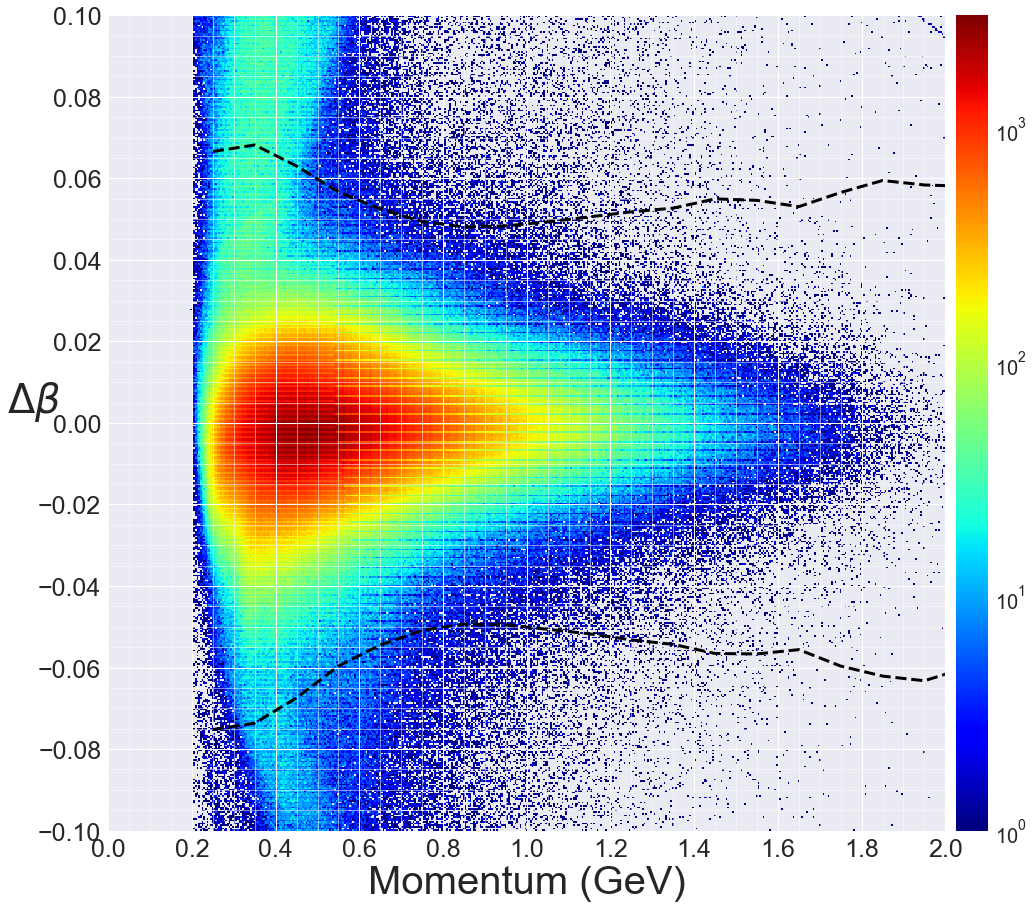

In [44]:
#beta diff (CHECK)
beta_diff = plt.figure(figsize=(15, 15))

plt.hist2d(df_GMSH["p_abs"], df_GMSH["beta_diff"], bins=500, cmap="jet", cmin=0, range=[[0, 2],[-0.1, 0.1]], \
           norm=mpl.colors.LogNorm())

# plt.hist2d(df_GMSH[df_GMSH["pid"]==14]["p_abs"], df_GMSH[df_GMSH["pid"]==14]["beta_diff"], bins=300, cmap="jet", cmin=0, range=[[0, 2],[-0.1, 0.1]], \
#            norm=mpl.colors.LogNorm())


#3sigma location
p_center_list = [0.5*(p_list[i] + p_list[i+1]) for i in range(len(p_list)-1)]
sig_3_up      = [popt_list[i][1] + 6*popt_list[i][2] for i in range(len(popt_list))]
sig_3_low     = [popt_list[i][1] - 6*popt_list[i][2] for i in range(len(popt_list))]
#Interpolate
sig_3_up_intp  = scipy.interpolate.interp1d(p_center_list, sig_3_up, kind="cubic")
sig_3_low_intp = scipy.interpolate.interp1d(p_center_list, sig_3_low, kind="cubic")
#Plot
plt.plot(p_center_list, sig_3_up_intp(p_center_list), "--", color="black", linewidth=3)
plt.plot(p_center_list, sig_3_low_intp(p_center_list), "--", color="black", linewidth=3)

plt.ylabel("$\Delta \\beta$", fontsize=40, rotation=0)
plt.xlabel("Momentum (GeV)", fontsize=40)
plt.xticks(np.round(np.arange(0, 2.1, 0.2), 2), fontsize=25)
plt.yticks(np.round(np.arange(-0.1, 0.11, 0.02), 2), fontsize=25)

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="w", linewidth=1.0)
plt.grid(b=True, which="minor", color="w", linewidth=0.5)

cbaxes = beta_diff.add_axes([0.91, 0.125, 0.03, 0.755])   # x_pos, y_pos, width, length
plt.colorbar(cax=cbaxes)
cbaxes.tick_params(labelsize=20)

plt.show()
# beta_diff.savefig("./run_period_1/beta_diff")

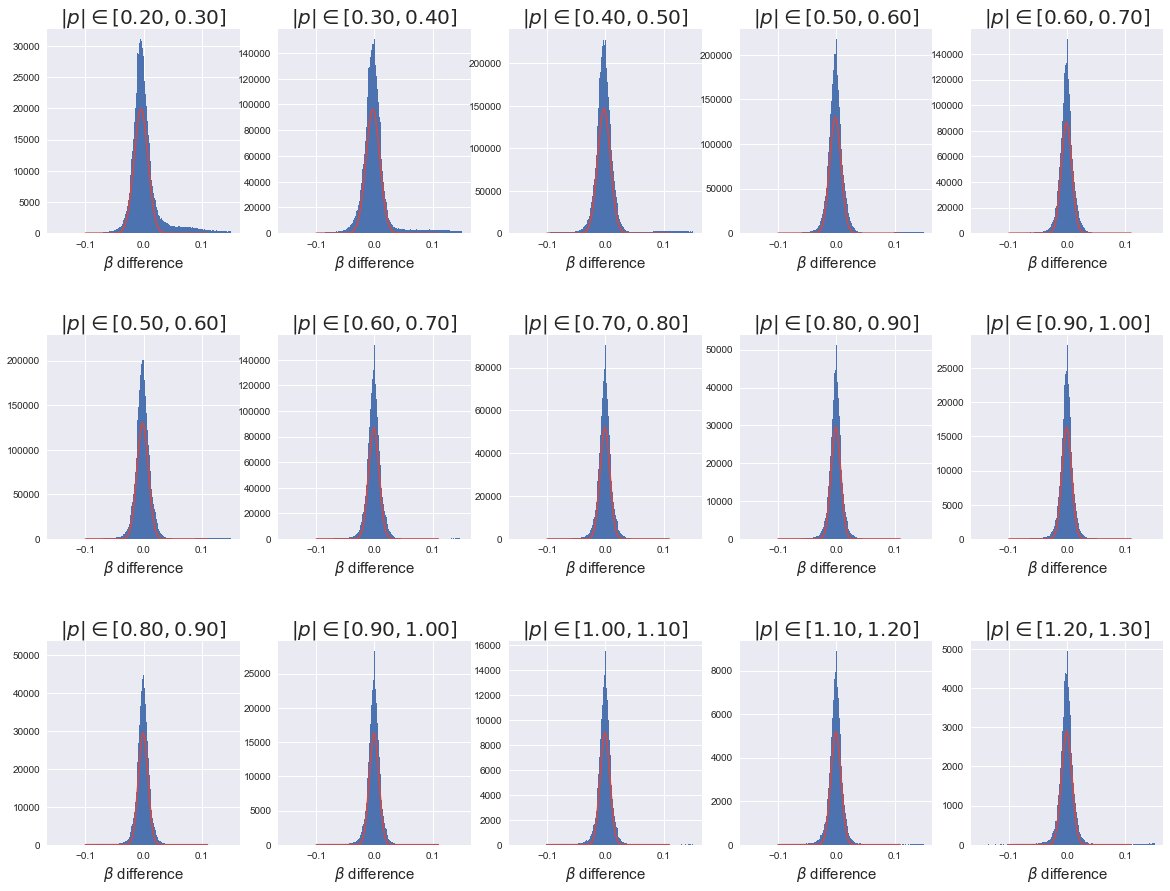

In [42]:
#Plot beta_diff for each p_abs bins defined in "partition_df_p" func (CHECK)
beta_diff_1hist, subplot = plt.subplots(3, 5, figsize=(20, 15))

#Plot
for i in range(3):
    for j in range(5):
        subplot[i, j].hist(df_tot_list[3*i+j]["beta_diff"], bins=200, range=(-0.15, 0.15))
        subplot[i, j].plot(bin_centers_list[3*i+j], fit_func(bin_centers_list[3*i+j], *(popt_list[3*i+j])), \
                           "-", color='#C44E52')
        
#Label
for i in subplot:
    for j in i:
        j.set_xlabel("$\\beta$ difference", fontsize=15)
        
#Title
for i in range(3):
    for j in range(5):
        subplot[i, j].set_title("$|p| \in [{:.2f}, {:.2f}]$".format(p_list[3*i+j], p_list[3*i+j]+0.1),  fontsize=20)
        
#Spacing
beta_diff_1hist.subplots_adjust(hspace=0.5)

plt.show()
# beta_diff_1hist.savefig("./run_period_1/beta_diff_1hist")

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


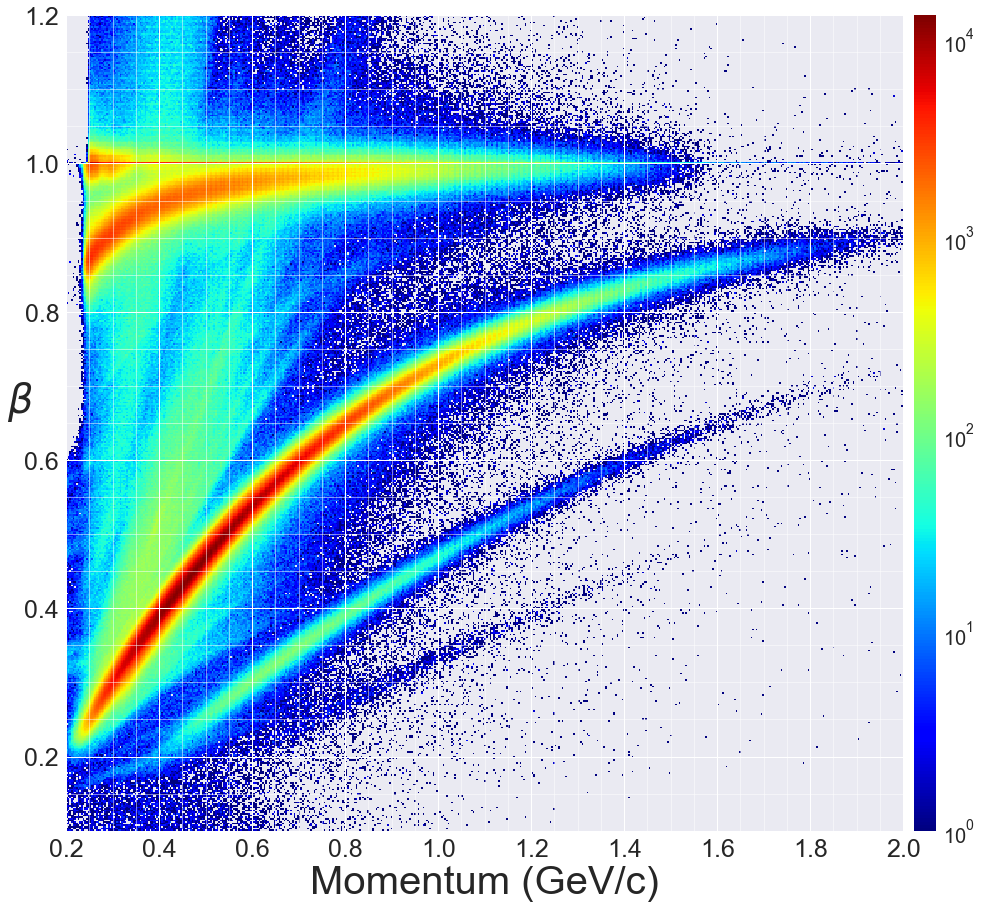

In [45]:
#beta vs p plot BEFORE (CHECK)
proton_select = plt.figure(figsize=(15,15))
plt.hist2d(df_GMSH.p_abs, df_GMSH.betam, bins=500, range=[[0.2, 2], [0.1, 1.2]], cmap="jet", cmin=0, \
           norm=mpl.colors.LogNorm())

plt.xlim(0.2, 2)
plt.ylim(0.1, 1.2)
plt.ylabel("$\\beta$", fontsize=40, rotation=0)
plt.xlabel("Momentum (GeV/c)", fontsize=40)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="w", linewidth=1.0)
plt.grid(b=True, which="minor", color="w", linewidth=0.5)

#Colorbar
cbaxes = proton_select.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=20)
plt.colorbar(cax=cbaxes)

plt.show
# proton_select.savefig("./run_period_1/proton_select_before")

In [46]:
# #Remove events outside of 6sigma (or 3, 4, 5, 6 sigmas) regions (MUST)
# for i in range(len(p_list)-1):
#     df_GMSH.drop(df_GMSH[(df_GMSH["p_abs"] > p_list[i]) & (df_GMSH["p_abs"] <= p_list[i+1])]
#                [(df_GMSH[(df_GMSH["p_abs"] > p_list[i]) & (df_GMSH["p_abs"] <= p_list[i+1])]["beta_diff"] < popt_list[i][1] - 6*popt_list[i][2]) | \
#                 (df_GMSH[(df_GMSH["p_abs"] > p_list[i]) & (df_GMSH["p_abs"] <= p_list[i+1])]["beta_diff"] > popt_list[i][1] + 6*popt_list[i][2])].index, inplace=True)

In [ ]:
#beta vs p plot AFTER (CHECK)
proton_select = plt.figure(figsize=(15,15))
plt.hist2d(df_GMSH.p_abs, df_GMSH.betam, bins=500, range=[[0.2, 2], [0.1, 1.2]], cmap="jet", cmin=0, \
           norm=mpl.colors.LogNorm())

plt.xlim(0.2, 2)
plt.ylim(0.1, 1.2)
plt.ylabel("$\\beta$", fontsize=40, rotation=0)
plt.xlabel("Momentum (GeV/c)", fontsize=40)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="w", linewidth=1.0)
plt.grid(b=True, which="minor", color="w", linewidth=0.5)

#Colorbar
cbaxes = proton_select.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=20)
plt.colorbar(cax=cbaxes)
# plt.clim(0, 500)

plt.show
# proton_select.savefig("./run_period_1/proton_select_after")

#### PART1: Photon selection 

In [ ]:
#Photon Selection 2D - dT vs p (CHECK)
photon_select_dt_p = plt.figure(figsize=(15, 15))

plt.hist2d(df_GMSH["p_abs"], df_GMSH["timediff"], bins=666, range=[[0.2, 2], [-6, 6]], cmap="jet", \
           norm=mpl.colors.LogNorm())

#Lines
plt.axhline(-1, linestyle="--", linewidth=3, color="black")
plt.axhline(1, linestyle="--", linewidth=3, color="black")

plt.xlim(0.2, 2)
plt.ylim(-6, 6)
plt.ylabel("$\Delta t_p$ [ns]", fontsize=50)
plt.xlabel("$p$ [GeV/c]", fontsize=50)
plt.xticks(fontsize=30, fontweight="ultralight")
plt.yticks(np.arange(-6, 6.1, 1) , fontsize=30, fontweight="ultralight")

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="gray", linewidth=1.0)
plt.grid(b=True, which="minor", color="gray", linewidth=0.5)

#Colorbar
cbaxes = photon_select_dt_p.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)

plt.show()
# photon_select_dt_p.savefig("./run_period_1/photon_select_dt_p")

In [ ]:
#Photon Selection 2D - dT vs \theta (CHECK)
photon_select_dt_theta = plt.figure(figsize=(15, 15))

plt.hist2d(df_GMSH["theta"], df_GMSH["timediff"], bins=666, range=[[0, 140], [-6, 6]], cmap="jet", \
           norm=mpl.colors.LogNorm())

#Lines
plt.axhline(-1, linestyle="--", linewidth=3, color="black")
plt.axhline(1, linestyle="--", linewidth=3, color="black")

plt.xlim(0, 140)
plt.ylim(-6, 6)
plt.ylabel("$\Delta t_p$ [ns]", fontsize=50)
plt.xlabel("$\\theta$ [deg]", fontsize=50)
plt.xticks(fontsize=30, fontweight="ultralight")
plt.yticks(np.arange(-6, 6.1, 1) , fontsize=30, fontweight="ultralight")

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(b=True, which="major", color="gray", linewidth=1.0)
plt.grid(b=True, which="minor", color="gray", linewidth=0.5)

#Colorbar
cbaxes = photon_select_dt_theta.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)

plt.show()
# photon_select_dt_theta.savefig("./run_period_1/photon_select_dt_theta")

In [241]:
#Drop events with bad photon and proton timings (MUST)
df_GMSH.drop(df_GMSH[df_GMSH["timediff"] > 1].index, inplace=True)
df_GMSH.drop(df_GMSH[df_GMSH["timediff"] < -1].index, inplace=True)

#### PART1: Inefficient TOF Paddles 

###### Run 1 

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/1000)
for i in sec:
    for j in i:
        j.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=25, fontweight="ultralight")

sec[0, 0].set_title("Sector 1", fontsize=25, fontweight="ultralight")
sec[0, 1].set_title("Sector 2", fontsize=25, fontweight="ultralight")
sec[0, 2].set_title("Sector 3", fontsize=25, fontweight="ultralight")
sec[1, 0].set_title("Sector 4", fontsize=25, fontweight="ultralight")
sec[1, 1].set_title("Sector 5", fontsize=25, fontweight="ultralight")
sec[1, 2].set_title("Sector 6", fontsize=25, fontweight="ultralight")

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [125]:
#Drop paddles (MUST)
df_GMSH.drop(df_GMSH[((df_GMSH["sector"]==2) & ((df_GMSH["tof_pad"]==38) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==3) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==4) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==32) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==36) | (df_GMSH["tof_pad"]==40) | (df_GMSH["tof_pad"]==42)))  | \
                     ((df_GMSH["sector"]==5) & ((df_GMSH["tof_pad"]==23))) | \
                     ((df_GMSH["sector"]==6) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==46)))].index, inplace=True)

###### Run 2

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/1000)
for i in sec:
    for j in i:
        j.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=25, fontweight="ultralight")

sec[0, 0].set_title("Sector 1", fontsize=25, fontweight="ultralight")
sec[0, 1].set_title("Sector 2", fontsize=25, fontweight="ultralight")
sec[0, 2].set_title("Sector 3", fontsize=25, fontweight="ultralight")
sec[1, 0].set_title("Sector 4", fontsize=25, fontweight="ultralight")
sec[1, 1].set_title("Sector 5", fontsize=25, fontweight="ultralight")
sec[1, 2].set_title("Sector 6", fontsize=25, fontweight="ultralight")

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), alpha=0.5)
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), alpha=0.5)
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), alpha=0.5)
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), alpha=0.5)
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), alpha=0.5)
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), alpha=0.5)

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=20)

sec[0, 0].set_title("Sector 1", fontsize=25)
sec[0, 1].set_title("Sector 2", fontsize=25)
sec[0, 2].set_title("Sector 3", fontsize=25)
sec[1, 0].set_title("Sector 4", fontsize=25)
sec[1, 1].set_title("Sector 5", fontsize=25)
sec[1, 2].set_title("Sector 6", fontsize=25)

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [140]:
#Drop paddles (MUST)
df_GMSH.drop(df_GMSH[((df_GMSH["sector"]==2) & ((df_GMSH["tof_pad"]==38) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==3) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==4) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==32) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==36) | (df_GMSH["tof_pad"]==40) | (df_GMSH["tof_pad"]==42)))  | \
                     ((df_GMSH["sector"]==5) & ((df_GMSH["tof_pad"]==23))) | \
                     ((df_GMSH["sector"]==6) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==46)))].index, inplace=True)

###### Run 3

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/1000)
for i in sec:
    for j in i:
        j.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=25, fontweight="ultralight")

sec[0, 0].set_title("Sector 1", fontsize=25, fontweight="ultralight")
sec[0, 1].set_title("Sector 2", fontsize=25, fontweight="ultralight")
sec[0, 2].set_title("Sector 3", fontsize=25, fontweight="ultralight")
sec[1, 0].set_title("Sector 4", fontsize=25, fontweight="ultralight")
sec[1, 1].set_title("Sector 5", fontsize=25, fontweight="ultralight")
sec[1, 2].set_title("Sector 6", fontsize=25, fontweight="ultralight")

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [156]:
#Drop paddles (MUST)
df_GMSH.drop(df_GMSH[((df_GMSH["sector"]==2) & ((df_GMSH["tof_pad"]==38) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==3) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==4) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==32) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==36) | (df_GMSH["tof_pad"]==40) | (df_GMSH["tof_pad"]==42)))  | \
                     ((df_GMSH["sector"]==5) & ((df_GMSH["tof_pad"]==23))) | \
                     ((df_GMSH["sector"]==6) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==46)))].index, inplace=True)

###### Run 4

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/1000)
for i in sec:
    for j in i:
        j.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=25, fontweight="ultralight")

sec[0, 0].set_title("Sector 1", fontsize=25, fontweight="ultralight")
sec[0, 1].set_title("Sector 2", fontsize=25, fontweight="ultralight")
sec[0, 2].set_title("Sector 3", fontsize=25, fontweight="ultralight")
sec[1, 0].set_title("Sector 4", fontsize=25, fontweight="ultralight")
sec[1, 1].set_title("Sector 5", fontsize=25, fontweight="ultralight")
sec[1, 2].set_title("Sector 6", fontsize=25, fontweight="ultralight")

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [214]:
#Drop paddles (MUST)
df_GMSH.drop(df_GMSH[((df_GMSH["sector"]==2) & ((df_GMSH["tof_pad"]==38) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==3) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==4) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==32) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==36) | (df_GMSH["tof_pad"]==40) | (df_GMSH["tof_pad"]==42)))  | \
                     ((df_GMSH["sector"]==5) & ((df_GMSH["tof_pad"]==23))) | \
                     ((df_GMSH["sector"]==6) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==46)))].index, inplace=True)

###### Run 5

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/1000)
for i in sec:
    for j in i:
        j.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=25, fontweight="ultralight")

sec[0, 0].set_title("Sector 1", fontsize=25, fontweight="ultralight")
sec[0, 1].set_title("Sector 2", fontsize=25, fontweight="ultralight")
sec[0, 2].set_title("Sector 3", fontsize=25, fontweight="ultralight")
sec[1, 0].set_title("Sector 4", fontsize=25, fontweight="ultralight")
sec[1, 1].set_title("Sector 5", fontsize=25, fontweight="ultralight")
sec[1, 2].set_title("Sector 6", fontsize=25, fontweight="ultralight")

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [226]:
#Drop paddles (MUST)
df_GMSH.drop(df_GMSH[((df_GMSH["sector"]==2) & ((df_GMSH["tof_pad"]==38) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==3) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==44)))       | \
                     ((df_GMSH["sector"]==4) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==32) | (df_GMSH["tof_pad"]==35) | (df_GMSH["tof_pad"]==36) | (df_GMSH["tof_pad"]==40) | (df_GMSH["tof_pad"]==42)))  | \
                     ((df_GMSH["sector"]==5) & ((df_GMSH["tof_pad"]==23))) | \
                     ((df_GMSH["sector"]==6) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==46)))].index, inplace=True)

###### Run 6

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/1000)
for i in sec:
    for j in i:
        j.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=25, fontweight="ultralight")

sec[0, 0].set_title("Sector 1", fontsize=25, fontweight="ultralight")
sec[0, 1].set_title("Sector 2", fontsize=25, fontweight="ultralight")
sec[0, 2].set_title("Sector 3", fontsize=25, fontweight="ultralight")
sec[1, 0].set_title("Sector 4", fontsize=25, fontweight="ultralight")
sec[1, 1].set_title("Sector 5", fontsize=25, fontweight="ultralight")
sec[1, 2].set_title("Sector 6", fontsize=25, fontweight="ultralight")

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [234]:
#Drop paddles (MUST)
df_GMSH.drop(df_GMSH[((df_GMSH["sector"]==1) & ((df_GMSH["tof_pad"]==17) | (df_GMSH["tof_pad"]==24) | (df_GMSH["tof_pad"]==26) | (df_GMSH["tof_pad"]==36)))       | \
                     ((df_GMSH["sector"]==2) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==45)))       | \
                     ((df_GMSH["sector"]==3) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==35)))       | \
                     ((df_GMSH["sector"]==4) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==42) | (df_GMSH["tof_pad"]==49)))  | \
                     ((df_GMSH["sector"]==5) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==52) | (df_GMSH["tof_pad"]==53)))       | \
                     ((df_GMSH["sector"]==6) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==46)))].index, inplace=True)

###### Run 7

In [ ]:
#Inefficient paddles in each sector
tof_ineff_pad, sec    = plt.subplots(2, 3, figsize=(20, 10))

sec[0, 0].hist(df_GMSH[df_GMSH["sector"]==1]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 1].hist(df_GMSH[df_GMSH["sector"]==2]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[0, 2].hist(df_GMSH[df_GMSH["sector"]==3]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 0].hist(df_GMSH[df_GMSH["sector"]==4]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 1].hist(df_GMSH[df_GMSH["sector"]==5]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")
sec[1, 2].hist(df_GMSH[df_GMSH["sector"]==6]["tof_pad"], bins=57, range=(0, 57), color="#4C72B0")

#For subplots
for i in sec:
    for j in i:
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Y-Axis Scaling
def adjust_y_axis(x, pos):
    return "{:.0f}".format(x/1000)
for i in sec:
    for j in i:
        j.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adjust_y_axis))

        
#ticks change fontsize
for i in sec:
    for j in i:
        j.tick_params(labelsize=15)        
        
for i in sec:
    for j in i:
        j.set_xlabel("Paddle #", fontsize=25, fontweight="ultralight")

sec[0, 0].set_title("Sector 1", fontsize=25, fontweight="ultralight")
sec[0, 1].set_title("Sector 2", fontsize=25, fontweight="ultralight")
sec[0, 2].set_title("Sector 3", fontsize=25, fontweight="ultralight")
sec[1, 0].set_title("Sector 4", fontsize=25, fontweight="ultralight")
sec[1, 1].set_title("Sector 5", fontsize=25, fontweight="ultralight")
sec[1, 2].set_title("Sector 6", fontsize=25, fontweight="ultralight")

tof_ineff_pad.subplots_adjust(hspace=0.4)
plt.show()
# tof_ineff_pad.savefig("./run_period_2/tof_ineff_pad")

In [242]:
#Drop paddles (MUST)
df_GMSH.drop(df_GMSH[((df_GMSH["sector"]==1) & ((df_GMSH["tof_pad"]==17) | (df_GMSH["tof_pad"]==24) | (df_GMSH["tof_pad"]==26) | (df_GMSH["tof_pad"]==36)))       | \
                     ((df_GMSH["sector"]==2) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==45)))       | \
                     ((df_GMSH["sector"]==3) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==35)))       | \
                     ((df_GMSH["sector"]==4) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==42) | (df_GMSH["tof_pad"]==49)))  | \
                     ((df_GMSH["sector"]==5) & ((df_GMSH["tof_pad"]==23) | (df_GMSH["tof_pad"]==52) | (df_GMSH["tof_pad"]==53)))       | \
                     ((df_GMSH["sector"]==6) & ((df_GMSH["tof_pad"]==44) | (df_GMSH["tof_pad"]==46)))].index, inplace=True)

#### PART1.5: ML quick (optional)

In [311]:
#Create dummy variable "T_fin" to hold estimated ML results
#    -Use when ML steps are not needed
#    -Only butanol and carbon
#    -Classify target according to target location

def T_fin(z_vtx):
    tfin = 0
    #Butanol
    #    -All events left of 3cm vtx position
    if (z_vtx<=3.5):
        tfin = 0
        
#     #Ice
#     elif(T_pred == 1 and ice_pred == 0):
#         tfin = 3

    #Carbon
    #    -All events right of 3cm vtx position
    elif (z_vtx>3.5):
        tfin = 1
        
#     #Polythene
#     elif(T_pred == 2):
#         tfin = 2

    return tfin
    
#Vectorize
vect_T_fin             = np.vectorize(T_fin, otypes=[np.int])
T_fin                  = vect_T_fin(df_GMSH["z"].values)

#Append to df
df_GMSH["T_fin"] = pd.Series(T_fin, index=df_GMSH.index)

In [ ]:
#Matplotlib hist2D ZY (CHECK)
zvtx_select = plt.figure(figsize=(15,15))
plt.hist2d(df_GMSH["z"][df_GMSH["T_fin"]==0], df_GMSH["y"][df_GMSH["T_fin"]==0], \
           bins=666, range=[[-10, 20], [-2, 1.75]], cmap="jet", cmin=0, norm=mpl.colors.LogNorm())
plt.xlim(-10, 20)
plt.ylim(-2, 1.75)
plt.xlabel("hit position z (cm)", fontsize=50)
plt.ylabel("hit position y (cm)", fontsize=50)

#Ticks
plt.xticks(np.arange(-10, 20, 2.5))
plt.xticks(fontsize=25, fontweight="ultralight")
plt.yticks(fontsize=25, fontweight="ultralight")

#Vertical line
plt.axvline(-3, linestyle="--", linewidth=3, color="black")
plt.axvline(3, linestyle="--", linewidth=3, color="black")
plt.axvline(5, linestyle="--", linewidth=3, color="black")
plt.axvline(8, linestyle="--", linewidth=3, color="black")
# plt.axvline(14, linestyle="--", linewidth=3, color="black")
# plt.axvline(18, linestyle="--", linewidth=3, color="black")

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
plt.grid(b=True, which="major", color="gray", linewidth=1.0)
plt.grid(b=True, which="minor", color="gray", linewidth=0.5)

cbaxes = zvtx_select.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)
# plt.colorbar(aspect=100)
# plt.clim(0, 200)
plt.show
# zvtx_select.savefig("./run_period_1/zvtx_select")

#### PART2: Z-Vertex Selection (AFTER ML & BEFORE SF)

##### Finding Selection Range for Butanol (STUDY) 

In [82]:
# #Read df from each runs (MUST)
# df_zvtx = pd.DataFrame()

# for i in [1, 2, 5, 6]:
#     df_zvtx_i = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_{:d}/df_GMSH_dstmaker_Ppi0_4_initial.pkl".format(i))\
#     [["epho", "tar_Pol", "tar_Pol_sign", "tar_Pol_stat", "cthe_cm", "bm_helicity", \
#       "pol_pho", "pol_pho_stat", "z", "el_pc_mmsq_pi0", "runNum"]]
    
#     #Select only the butanol events
#     df_zvtx_i = df_zvtx_i[(df_zvtx_i["z"] >= -4.) & (df_zvtx_i["z"] <= 4.)]
    
#     #Select only subset of events with good free nucleon peaks and similar looking
#     #    -See mmsq overall plot to determine these
#     df_zvtx_i = df_zvtx_i[(df_zvtx_i["epho"] >= 0.84) & (df_zvtx_i["epho"] <= 1.27) & \
#                           (df_zvtx_i["cthe_cm"] >= -0.97) & (df_zvtx_i["cthe_cm"] <= 0.0)]
    
#     #Append
#     df_zvtx = df_zvtx.append(df_zvtx_i, ignore_index=True)

# df_zvtx = df_zvtx.reset_index(drop=True)

In [83]:
#Optimized Version - Vectorization numpy (MUST)
#    -rerun pol_pho_stat since calculation has been updated in 2021/05_05
def comp_pho_Pol_stat(epho, runNum):
    pol_pho_stat = 0
    
    #E_Beam for run ranges
    if   (runNum >= 55521 and runNum <= 55536):
        E_ebeam   = 1.647
    elif (runNum >= 55537 and runNum <= 55552):
        E_ebeam   = 1.647
    elif (runNum >= 55557 and runNum <= 55594):
        E_ebeam   = 1.647
    elif (runNum >= 55604 and runNum <= 55625):
        E_ebeam   = 2.478
    elif (runNum >= 55630 and runNum <= 55678):
        E_ebeam   = 2.478
    elif (runNum >= 56164 and runNum <= 56193):
        E_ebeam   = 2.478
    elif (runNum >= 56196 and runNum <= 56233):
        E_ebeam   = 2.478
        
    #Error for Polarization of E beam for measured run ranges [Steffen AN sec3.1]
    #CORRECT value used since 2021_05
    ebeam_stat_err = 0.035
    
    #WRONG value used until 2021_05
    #ebeam_stat_err = 1.399
    
    #Variables
    x              = epho / E_ebeam
    x2             = x*x
    pol_pho_stat   = np.sqrt((ebeam_stat_err**2) * ((4*x - x2) / (4 - 4*x + 3*x2))**2)
    
    return pol_pho_stat

#Vectorize
vect_comp_pho_Pol_stat = np.vectorize(comp_pho_Pol_stat, otypes=[np.float])
pol_pho_stat           = vect_comp_pho_Pol_stat(df_zvtx["epho"].values, df_zvtx["runNum"].values)

#Append to df
df_zvtx["pol_pho_stat"] = pd.Series(pol_pho_stat, index=df_zvtx.index)

In [84]:
#RAW HAE (MUST) 
#   -Without scale factor and dilution factor 
#   -Partition in z=0.1cm as [Hao pg9]
def raw_HAE(df=pd.DataFrame()):
    
    #============================================================================================
    #List to hold Z
    raw_E_list     = []
    raw_E_err_list = []
    
    #Z partition
    z_bins = [i/10 for i in range(-40, 41, 1)]
    
    #============================================================================================
    #For each zvtx bins
    for z_bin in range(len(z_bins)-1):

        #df in each z_bin intervals
        df_z = df[(df["z"] >= z_bins[z_bin]) & (df["z"] <= z_bins[z_bin+1])]
    
        #========================================================================================================
        #MMSQ PEAK SELECTION - ONLY FOR raw_HAE(), OMIT THIS PART FOR REAL HAE COMPUTATION

        #Histogram
        bin_num = 5*int(np.sqrt(len(df_z)))
        data       = np.array(df_z["el_pc_mmsq_pi0"])
        hist, bins = np.histogram(data, bins=bin_num)
    
        #Stats
        peak = bins[np.argmax(hist)]
        mids   = [0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)]
        mean   = np.average(mids, weights=hist)
        var    = np.average((mids - mean)**2, weights=hist)
        stddev = np.sqrt(var)        
        
        #MMSQ Peak Selection ranges
        #    -Change this part to probe
        mmsq_peak_range_list = [peak - 1*stddev, peak + 1*stddev]

        #Select events withn MMSQ peak regions
        df_z = df_z[(df_z["el_pc_mmsq_pi0"] > mmsq_peak_range_list[0]) & \
                                  (df_z["el_pc_mmsq_pi0"] < mmsq_peak_range_list[1])]
    
        #========================================================================================================
        #Target polarization
        pol_tar      = np.abs(df["tar_Pol"].astype(float)).mean()

        #========================================================================================================
        #PARA and ANPA 
        #    -THIS SHOULD VARY DEPENDING ON TARGET POLARIZATION + bm_helicity
        PARA = len(df_z[(df_z["tar_Pol_sign"]==-1) & (df_z["bm_helicity"]==-1)]) + \
               len(df_z[(df_z["tar_Pol_sign"]==1)  & (df_z["bm_helicity"]==1)])

        ANPA = len(df_z[(df_z["tar_Pol_sign"]==-1) & (df_z["bm_helicity"]==1)]) + \
               len(df_z[(df_z["tar_Pol_sign"]==1)  & (df_z["bm_helicity"]==-1)])           
        
        #========================================================================================================
        #Photon Polarization
        pol_pho_avg = df["pol_pho"].astype(float).mean()
        
        #dilution factor set to 1 for raw assym
        dil_fact = 1
        
        #========================================================================================================
        #Compute HAE
        if((PARA + ANPA) == 0):
            HAE = np.nan

        #If good bins - HAE EQUATION HERE!!!
        else:
            HAE = (1/pol_pho_avg) * (1/(pol_tar)) * ((ANPA - PARA) / (PARA + ANPA))
            HAE = round(HAE, 7)
        
        #========================================================================================================
        #Statistical Uncertainty 
        
        #Target polarization error
        pol_tar_err = np.sqrt(np.sum(pow(df_z["tar_Pol_stat"], 2) / len(df_z)))

        #Photon polarization error
        pol_pho_avg_stat_err = np.sqrt(np.sum(pow(df_z["pol_pho_stat"], 2) / len(df_z)))
    
        #Fianl HAE_stat_err compute
        try:
            #W/ df_stat_err
            HAE_stat_err = np.sqrt(pow(HAE, 2)*(pow((pol_tar_err/pol_tar), 2) + \
                                                pow((pol_pho_avg_stat_err/pol_pho_avg), 2) + \
                                                (4*ANPA*PARA)/((ANPA + PARA)*pow((PARA - ANPA),2))))                

        except ZeroDivisionError:
            HAE_stat_err = np.nan

        #========================================================================================================
        #Append to final list
        raw_E_list.append(HAE)
        raw_E_err_list.append(HAE_stat_err)
        
    return raw_E_list, raw_E_err_list

In [85]:
#Avergage MMSQ in poor vertex resolution bins (MUST)
def avg_MMSQ(df=pd.DataFrame()):
    
    #============================================================================================
    #Dictionary to hold list of E values and dilution values
    avg_MMSQ_list     = []
    avg_MMSQ_err_list = []        
    
    #Z partition
    z_bins = [i/10 for i in range(-40, 41, 1)]
        
    #============================================================================================
    #For each zvtx bins
    for z_bin in range(len(z_bins)-1):

        #df in each z_bin intervals
        df_z = df[(df["z"] >= z_bins[z_bin]) & (df["z"] <= z_bins[z_bin+1])][["z", "el_pc_mmsq_pi0"]]
        
        #============================================================================================
        #Stats
        mmsq     = df_z["el_pc_mmsq_pi0"].mean()
        mmsq_err = df_z["el_pc_mmsq_pi0"].std()

        #============================================================================================
        #Append
        avg_MMSQ_list.append(mmsq)
        avg_MMSQ_err_list.append(mmsq_err)
        
    return avg_MMSQ_list, avg_MMSQ_err_list

In [86]:
#Apply raw_E_dict() (MUST)
raw_E_list, raw_E_err_list = raw_HAE(df_zvtx)

In [87]:
#Apply avg_MMSQ() (MUST)
avg_MMSQ_list, avg_MMSQ_err_list = avg_MMSQ(df_zvtx)

In [ ]:
#Plot zvtx study
zvtx_buta, subplot = plt.subplots(3, 1, sharex=True, figsize=(20,15))

#bin centers
z_bins = [i/10 for i in range(-40, 41, 1)]
z_mids = [round(0.5*(z_bins[i] + z_bins[i+1]), 3) for i in range(len(z_bins)-1)]

#plot
subplot[0].errorbar(z_mids, raw_E_list, yerr=raw_E_err_list, \
                    fmt="o", markeredgewidth=1, capsize=5, elinewidth=1, color="#4C72B0")

subplot[1].errorbar(z_mids, avg_MMSQ_list, yerr=avg_MMSQ_err_list, \
                    fmt="o", markeredgewidth=1, capsize=5, elinewidth=1, color="#4C72B0")
subplot[2].hist(df_zvtx["z"], bins="fd", color="#4C72B0", histtype="step", linewidth=2)


#grids, Ticks size
for j in subplot:
    j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    j.grid(b=True, which="major", color="gray", linewidth=.5, linestyle="--")
    j.grid(b=True, which="minor", color="gray", linewidth=0.25, linestyle="--")
    #Ticks size
    j.tick_params(labelsize=25)

#axvlines
for i in subplot:
    i.axvline(-3, linestyle="--", lw=3, color="#C44E52", alpha=0.75)
    i.axvline(3, linestyle="--", lw=3, color="#C44E52", alpha=0.75)
#axhline for asymmetry
subplot[0].axhline(0, linestyle="--", lw=2, color="black", alpha=0.5)    
    
#Set YLabel, XLabel, ylim, xlim
subplot[-1].set_xlim(-4, 4)
subplot[-1].set_xlabel("z-vertex [cm]", fontsize=40)
subplot[0].set_ylabel("Raw E", fontsize=30)
subplot[1].set_ylabel("$ M_X^2$ mean", fontsize=30)
subplot[-1].set_ylabel("Counts", fontsize=30)
subplot[0].set_ylim(-0.2, 0.2)
subplot[1].set_ylim(-.25, .75)
# subplot[2].set_ylim(-1., 1.)

#Text    
subplot[0].text(.95, 0.9, "(a)", fontsize=20, transform=subplot[0].transAxes)
subplot[1].text(.95, 0.9, "(b)", fontsize=20, transform=subplot[1].transAxes)
subplot[2].text(.95, 0.9, "(c)", fontsize=20, transform=subplot[2].transAxes)

#Spacing
zvtx_buta.subplots_adjust(hspace=0.)

plt.show()
# zvtx_buta.savefig("./zvtx_buta_study")

In [34]:
# #Function to make the plot (OLD)
# def plot_zvtx_rawHAE_mmsq(df=pd.DataFrame(), epho_bins=[], epho_lim={}, cos_bins=[], zvtx_bins=[], \
#                           raw_E_dict={}, raw_E_err_dict={}, avg_MMSQ_dict={}, avg_MMSQ_err_dict={}, \
#                           peak_MMSQ_dict={}, iterator = 0):
    
#     #Plot raw_HAE, avg_MMSQ, zvtx count VS z-vertex
#     zvtx_select_range, subplot = plt.subplots(4, 1, sharex=True, figsize=(15, 15))

#     #Keys and zvtx_bins centers
#     keys             = [i for i in raw_E_dict.keys()]
#     zvtx_bins_center = [round(0.5 * (zvtx_bins[i] + zvtx_bins[i+1]), 2) for i in range(len(zvtx_bins) - 1)]

#     #Plot
#     subplot[0].errorbar(zvtx_bins_center, raw_E_dict[keys[iterator]], yerr=raw_E_err_dict[keys[iterator]], \
#                         fmt="o", markeredgewidth=1, capsize=5, elinewidth=1, color="#4C72B0")

#     subplot[1].errorbar(zvtx_bins_center, avg_MMSQ_dict[keys[iterator]], yerr=avg_MMSQ_err_dict[keys[iterator]], \
#                         fmt="o", markeredgewidth=1, capsize=5, elinewidth=1, color="#4C72B0")

#     subplot[2].errorbar(zvtx_bins_center, peak_MMSQ_dict[keys[iterator]], yerr=avg_MMSQ_err_dict[keys[iterator]], \
#                         fmt="o", markeredgewidth=1, capsize=5, elinewidth=1, color="#4C72B0")
    
#     subplot[3].hist(df[(df["epho"] > epho_lim["low_lim"]) & \
#                             (df["epho"] <= epho_lim["up_lim"]) & \
#                             (df["cthe_cm"] > cos_bins[iterator]) & \
#                             (df["cthe_cm"] < cos_bins[iterator+1])]["z"], \
#                     bins="fd", color="#4C72B0", histtype="step", linewidth=2)
    
#     #Stats
#     #mean for raw HAE
#     raw_HAE_mean    = np.mean(raw_E_dict[keys[iterator]])
#     #Mode for mmsq
#     #mmsq_hist, bins = np.histogram(avg_MMSQ_dict[keys[iterator]], bins="fd")
#     #mmsq_peak       = bins[np.argmax(mmsq_hist)]
    
#     #Text
#     subplot[0].text(0.7, 0.9, "Raw Asym. E Mean = {:.3f}".format(raw_HAE_mean), fontsize=15, bbox={"facecolor":"none", "pad":4}, \
#                     transform=subplot[0].transAxes)
#     #subplot[1].text(0.7, 0.9, "MMSQ Peak = {:.3f}".format(mmsq_peak), fontsize=15, bbox={"facecolor":"none", "pad":4}, \
#     #                transform=subplot[1].transAxes)

#     #axvlines
#     for i in subplot:
#         i.axvline(-3, linestyle="--", lw=3, color="#C44E52", alpha=0.5)
#         i.axvline(3, linestyle="--", lw=3, color="#C44E52", alpha=0.5)
#     #axhline for asymmetry
#     subplot[0].axhline(0, linestyle="-", lw=3, color="black", alpha=0.5)
#     #axhline for mmsq mode
#     #subplot[1].axhline(mmsq_peak, linestyle="-", lw=3, color="black", alpha=0.5)

#     #grids, Ticks size
#     for j in subplot:
#         j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
#         j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
#         j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
#         j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")

#         #Ticks size
#         j.tick_params(labelsize=15)

#     #Set YLabel, XLabel, ylim, xlim
#     subplot[-1].set_xlim(-4, 4)
#     subplot[-1].set_xlabel("z-vertex [cm]", fontsize=20)
#     subplot[0].set_ylabel("Raw Asym. E", fontsize=15)
#     subplot[1].set_ylabel("MMSQ Mean$ [GeV^2]$", fontsize=15)
#     subplot[2].set_ylabel("MMSQ Peak$ [GeV^2]$", fontsize=15)
#     subplot[-1].set_ylabel("Counts", fontsize=20)
#     subplot[0].set_ylim(-0.5, 0.5)
#     subplot[1].set_ylim(-1., 1.)
#     subplot[2].set_ylim(-1., 1.)

#     #Set Title
#     zvtx_select_range.text(0.5, 0.91, "$E_{{\gamma}}$ = [{:.2f}, {:.2f}] [GeV] \t $COS\\theta_{{cm}}$ = [{:.2f}, {:.2f}] [deg]"\
#                            .format(epho_lim["low_lim"], epho_lim["up_lim"], cos_bins[iterator], cos_bins[iterator+1]), \
#                            fontsize=25, ha="center")
#     #Set Title
#     #zvtx_select_range.text(0.5, 0.91, "$E_{{\gamma}}$ = [{:.2f}, {:.2f}] [GeV] \t $\\theta_{{lab}}$ = [{:.2f}, {:.2f}] [deg]"\
#     #                       .format(epho_lim["low_lim"], epho_lim["up_lim"], theta_lab_bins[iterator], theta_lab_bins[iterator+1]), \
#     #                       fontsize=25, ha="center")    
    

#     #Spacing
#     zvtx_select_range.subplots_adjust(hspace=0.)

#     plt.show()
#     zvtx_select_range.savefig("./run_period_1/zvtx_select_range_{:2d}".format(iterator))    

In [ ]:
# #Call ploting function in all cos_bins (OLD)
# for i in range(len(cos_bins)-1):
# # for i in range(1):
#     plot_zvtx_rawHAE_mmsq(df=df_zvtx, epho_bins=epho_bins, epho_lim=epho_lim, cos_bins=cos_bins, \
#                           zvtx_bins=zvtx_bins, \
#                           raw_E_dict=raw_E_dict, raw_E_err_dict=raw_E_err_dict, \
#                           avg_MMSQ_dict=avg_MMSQ_dict, avg_MMSQ_err_dict=avg_MMSQ_err_dict, \
#                           peak_MMSQ_dict=peak_MMSQ_dict, iterator=i)

In [6]:
# #Avergage HAE in poor vertex resolution bins (OLD)
# #   -Without scale factor and dilution factor 
# def raw_HAE(df=pd.DataFrame(), epho_bins=[], cos_bins=[], epho_lim={}, zvtx_bins=[]):
    
#     #============================================================================================
#     #Dictionary to hold list of E values and dilution values
#     raw_E_dict     = {}
#     raw_E_err_dict = {}
    
#     #============================================================================================
#     #photon energy range
#     df_epho = df[["tar_Pol", "tar_Pol_sign", "tar_Pol_stat", "cthe_cm", "bm_helicity", "pol_pho", \
#                   "pol_pho_stat", "z", "el_pc_mmsq_pi0"]] \
#                 [(df["epho"] > epho_lim["low_lim"]) & (df["epho"] <= epho_lim["up_lim"])]
    
#     #========================================================================================================
#     #For each cos_bin
#     for j in range(len(cos_bins)-1):
#         df_epho_cos = df_epho[["bm_helicity", "pol_pho", "pol_pho_stat", \
#                                "tar_Pol", "tar_Pol_sign", "tar_Pol_stat", "z", "el_pc_mmsq_pi0"]] \
#                              [(df_epho["cthe_cm"] > cos_bins[j]) & (df_epho["cthe_cm"] < cos_bins[j+1])]

#         #inner list: For each angle bin, containg a scalar for each zvtx bin
#         E_1epho_1cos_zvtx_list     = []
#         E_err_1epho_1cos_zvtx_list = []
        
#         #========================================================================================================
#         #MMSQ PEAK SELECTION - ONLY FOR raw_HAE(), OMIT THIS PART FOR REAL HAE COMPUTATION
        
#         #Histogram for MMSQ
#         data       = np.array(df_epho_cos["el_pc_mmsq_pi0"])
#         hist, bins = np.histogram(data, bins=1000)
        
#         #Peak
#         peak = bins[np.argmax(hist)]
        
#         #Stddev
#         mids   = [0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)]
#         mean   = np.average(mids, weights=hist)
#         var    = np.average((mids - mean)**2, weights=hist)
#         stddev = np.sqrt(var)
        
#         #MMSQ Peak Selection ranges
#         #    -Change this part to probe
#         mmsq_peak_range_list = [peak - 2*stddev, peak + 2*stddev]
        
#         #Select events withn MMSQ peak regions
#         df_epho_cos = df_epho_cos[(df_epho_cos["el_pc_mmsq_pi0"] > mmsq_peak_range_list[0]) & \
#                                   (df_epho_cos["el_pc_mmsq_pi0"] < mmsq_peak_range_list[1])]
        
#         #Print
#         #print("mmsq_peak_range_list = ", mmsq_peak_range_list[0], mmsq_peak_range_list[1])
#         #print("# of events          = ", len(df_epho_cos))
        
#         #========================================================================================================
#         #For each zvtx bins
#         for k in range(len(zvtx_bins)-1):
#             df_epho_cos_zvtx = df_epho_cos[["bm_helicity", "pol_pho", "pol_pho_stat", \
#                                             "tar_Pol", "tar_Pol_sign", "tar_Pol_stat"]] \
#                                           [(df_epho_cos["z"] > zvtx_bins[k]) & \
#                                            (df_epho_cos["z"] < zvtx_bins[k+1])]

#             #Scalers to append to inner lists defined above
#             E_1bin          = 0
#             E_stat_err_1bin = 0
            
#             #Target polarization 
#             #    -Average over same target polarization sign period
#             pol_tar      = np.abs(df_epho_cos_zvtx["tar_Pol"].astype(float).mean())
#             pol_tar_sign = df_epho_cos_zvtx["tar_Pol_sign"].mode()[0]
            
#             #Photon polarization
#             pol_pho_raw  = df_epho_cos_zvtx["pol_pho"].astype(float).mean()
            
#             #Dilution Facot
#             #    -CHANGE THIS PART LATER.
#             dil_fact = 1

#             #Total Helicity States - PARA and ANPA 
#             #    -THIS SHOULD VARY DEPENDING ON TARGET POLARIZATION + bm_helicity
#             #    -Only use BUTANOL EVENTS for computing HAE (carbon + butanol events for dilusion)
#             if (pol_tar_sign == -1):
#                 PARA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == -1)])
#                 ANPA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == 1)])
#             elif (pol_tar_sign == 1):
#                 PARA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == 1)])
#                 ANPA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == -1)])
            
#             #FOR real HAE computation
#             #if (pol_tar_sign == -1):
#             #    PARA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == -1) & (df_epho_cos_zvtx["T_fin"] == 0)])
#             #    ANPA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == 1) & (df_epho_cos_zvtx["T_fin"] == 0)])
#             #elif (pol_tar_sign == 1):
#             #    PARA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == 1) & (df_epho_cos_zvtx["T_fin"] == 0)])
#             #    ANPA = len(df_epho_cos_zvtx[(df_epho_cos_zvtx["bm_helicity"] == -1) & (df_epho_cos_zvtx["T_fin"] == 0)])
            
#             #========================================================================================================
#             #HAE Computation
#             if ((PARA + ANPA) == 0):
#                 E_1bin = np.nan
#             else:
#                 E_1bin = (1/dil_fact) * (1/pol_pho_raw) * (1/(pol_tar)) * ((ANPA - PARA) / (PARA + ANPA))
#                 E_1bin = round(E_1bin, 4)
                             
#             #========================================================================================================
#             #UNCERTAINTY - STATISTICAL 
            
#             #Target polarization statistical error
#             pol_tar_err = np.sqrt(1 / np.sum(1 / pow(df_epho_cos_zvtx["tar_Pol_stat"].astype(float), 2)))
            
#             #Photon Polarization Statistical Uncertainty for each \theta bin
#             pol_pho_err = np.sqrt(1 / np.sum(1 / pow(df_epho_cos_zvtx["pol_pho_stat"].astype(float), 2)))
            
#             #Final HAE statistical uncertainty for each theta bin: Error propagation
#             try:
#                 E_stat_err_1bin = np.sqrt(pow(E_1bin, 2)*(pow((pol_tar_err/pol_tar), 2) + \
#                                                           pow((pol_pho_err/pol_pho_raw), 2) + \
#                                                           (4*ANPA*PARA)/((ANPA + PARA)*pow((PARA - ANPA),2))))
#                 E_stat_err_1bin = round(E_stat_err_1bin, 4)
#             except ZeroDivisionError:
#                 E_stat_err_1bin = 0    
    
#             #========================================================================================================
#             #Append to inner list
#             E_1epho_1cos_zvtx_list.append(E_1bin)
#             E_err_1epho_1cos_zvtx_list.append(E_stat_err_1bin)
    
#         #==============================================================================================         
#         #Append to sf_eg_list to dict
#         raw_E_dict["COS_{:07.3f}".format(cos_bins[j])]     = E_1epho_1cos_zvtx_list
#         raw_E_err_dict["COS_{:07.3f}".format(cos_bins[j])] = E_err_1epho_1cos_zvtx_list
        
#     return raw_E_dict, raw_E_err_dict    

In [7]:
# #Avergage MMSQ in poor vertex resolution bins (OLD)
# def avg_MMSQ(df=pd.DataFrame(), epho_bins=[], cos_bins=[], epho_lim={}, zvtx_bins=[]):
    
#     #============================================================================================
#     #Dictionary to hold list of E values and dilution values
#     avg_MMSQ_dict     = {}
#     peak_MMSQ_dict    = {}
#     avg_MMSQ_err_dict = {}        
    
#     #============================================================================================
#     #photon energy range
#     df_epho = df[["cthe_cm", "z", "el_pc_mmsq_pi0"]] \
#                 [(df["epho"] > epho_lim["low_lim"]) & (df["epho"] < epho_lim["up_lim"])]    
    
#     #========================================================================================================
#     #For each cos_bin
#     for j in range(len(cos_bins)-1):
#         df_epho_cos = df_epho[["z", "el_pc_mmsq_pi0"]] \
#                              [(df_epho["cthe_cm"] > cos_bins[j]) & (df_epho["cthe_cm"] < cos_bins[j+1])]

#         #inner list: For each angle bin, containg a scalar for each zvtx bin
#         MMSQ_1epho_1cos_zvtx_list       = []
#         MMSQ_peak_1epho_1cos_zvtx_list  = []
#         MMSQ_err_1epho_1cos_zvtx_list   = []    
    
#         #========================================================================================================
#         #For each zvtx bins
#         for k in range(len(zvtx_bins)-1):
#             df_epho_cos_zvtx = df_epho_cos[["el_pc_mmsq_pi0"]] \
#                                           [(df_epho_cos["z"] > zvtx_bins[k]) & \
#                                            (df_epho_cos["z"] < zvtx_bins[k+1])]

#             #MMSQ Histogramming
#             mmsq_hist, bins = np.histogram(np.array(df_epho_cos_zvtx["el_pc_mmsq_pi0"]), bins=100)
#             mids            = [0.5*(bins[i] + bins[i+1]) for i in range(len(bins)-1)]
#             mean            = np.average(mids, weights=mmsq_hist)
#             var             = np.average((mids-mean)**2, weights=mmsq_hist)
#             stddev          = np.sqrt(var)
#             peak            = bins[np.argmax(mmsq_hist)]

#             #Scalers to append to inner lists defined above
#             MMSQ_1bin          = mean
#             MMSQ_peak_1bin     = peak
#             MMSQ_stat_err_1bin = stddev
            
#             #See which bins have poor binning
#             #if (np.abs(mean) - np.abs(peak) > 0.2):
#             #    print("cos_bins  = ", cos_bins[j])
#             #    print("zvtx_bins = ", zvtx_bins[k])
    
#             #========================================================================================================
#             #Append to inner list
#             MMSQ_1epho_1cos_zvtx_list.append(MMSQ_1bin)
#             MMSQ_peak_1epho_1cos_zvtx_list.append(MMSQ_peak_1bin)
#             MMSQ_err_1epho_1cos_zvtx_list.append(MMSQ_stat_err_1bin)
    
#         #==============================================================================================         
#         #Append to sf_eg_list to dict
#         avg_MMSQ_dict["COS_{:07.3f}".format(cos_bins[j])]     = MMSQ_1epho_1cos_zvtx_list
#         peak_MMSQ_dict["COS_{:07.3f}".format(cos_bins[j])]    = MMSQ_peak_1epho_1cos_zvtx_list
#         avg_MMSQ_err_dict["COS_{:07.3f}".format(cos_bins[j])] = MMSQ_err_1epho_1cos_zvtx_list
        
#     return avg_MMSQ_dict, peak_MMSQ_dict, avg_MMSQ_err_dict

##### Finding Selection Range for Carbon (STUDY) 

In [ ]:
#Notes
"""
* Find the Peaking behaviour in each bins for carbon events
    * Select events in peaking regions and plot z-vertex positions.
    
* Compare results WITH and WITHOUT ML
    * With ML: Current version where I use "T_fin" from ML result
    * W/O  ML: Partition butanol and carbon based on ZVTX positions

* Double cos_bin width to include more statistics [Steffen fig23]

* Vary the carbon selection range and observe whether the MMSQ peak is chaning

"""

#Results
"""
* NO difference betwwen ML and w/o ML cases, since current ML isn't working properly
* No unusal peaks in the range where Steffen found ice: [6, 8] cm.

* When doubled the bin width for cos\theta bins, sharp peaks were visible 

* Peaks are in forward angles as Eugene suggested to look
    * cthe_cm = [-1.0, 0.2]
    
* Carbon selection range = [5, 6] removed most of the sharp peaking behaviour
    
"""

###### With ML (USE)

In [142]:
#NEW Bins and limits (MUST)

#Epho bins as determined in Binning section, summing all run periods
epho_bins = [0.35, 0.4, 0.44, 0.48, 0.54, 0.56, 0.58, 0.61, 0.65, 0.68, 0.71, 0.75, 0.8, 0.84, 0.9, 0.96, 1.04, 1.14, 1.26, 1.41, 1.6]

#\theta_cm bins (MUST)
cos_bins = np.arange(-1.0, 1.01, 0.4)
# cos_bins = np.arange(-1.0, 1.01, 0.1)
cos_bins = [round(float(i), 3) for i in cos_bins]

#Theta_lab bins
# theta_lab_bins_percentiles = np.arange(0, 1.01, 0.1)
# theta_lab_bins = df_GMSH["theta"].quantile(theta_lab_bins_percentiles).tolist()
# theta_lab_bins = [round(i, 2) for i in theta_lab_bins]

#Range of interested epho bins
epho_lim = {"low_lim":1., "up_lim":1.1}
# epho_lim = {"low_lim":1.0, "up_lim":1.15}
# epho_lim = {"low_lim":0, "up_lim":0.5}

#Z-vertex bins
# zvtx_bins = np.arange(-4, 4.01, 0.05)
# zvtx_bins = np.arange(-4, 4.01, 0.5)
zvtx_bins = np.arange(-4, 4.01, 0.25)
zvtx_bins = [round(float(i), 3) for i in zvtx_bins]

#Print
print("epho_bins      = ", epho_bins)
print("cos_bins      = ", cos_bins)
print("epho_lim       = ", epho_lim)
print("zvtx_binss     = ", zvtx_bins)
# print("theta_lab_bins = ", theta_lab_bins)

epho_bins      =  [0.35, 0.4, 0.44, 0.48, 0.54, 0.56, 0.58, 0.61, 0.65, 0.68, 0.71, 0.75, 0.8, 0.84, 0.9, 0.96, 1.04, 1.14, 1.26, 1.41, 1.6]
cos_bins      =  [-1.0, -0.6, -0.2, 0.2, 0.6, 1.0]
epho_lim       =  {'low_lim': 1.0, 'up_lim': 1.1}
zvtx_binss     =  [-4.0, -3.75, -3.5, -3.25, -3.0, -2.75, -2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]


In [143]:
#Partition df in epho & cos bins (MUST for CHECK)
def part_df(df=pd.DataFrame(), epho_bins=[], cos_bins=[]):
    #================================================================================================================
    #Dictionaries to data frames for each energy + angle bins
    buta_dict = {}
    carb_dict = {}
    
    #================================================================================================================
    #For each targets
    df_buta   = df[["cthe_cm", "epho", "el_pc_mmsq_pi0", "T_fin", "z"]][(df["T_fin"] == 0) & (df["el_pc_mmsq_pi0"] > -1.5) & (df["el_pc_mmsq_pi0"] < 1)]
    df_carb   = df[["cthe_cm", "epho", "el_pc_mmsq_pi0", "T_fin", "z"]][(df["T_fin"] == 1) & (df["el_pc_mmsq_pi0"] > -1.5) & (df["el_pc_mmsq_pi0"] < 1)]

    #================================================================================================================
    #For each Eg_bon
    for i in range(len(epho_bins)-1):
        df_buta_Eg = df_buta[["cthe_cm", "el_pc_mmsq_pi0", "z"]] \
                [(df_buta["epho"] > epho_bins[i]) & (df_buta["epho"] < epho_bins[i+1])]
        
        df_carb_Eg = df_carb[["cthe_cm", "el_pc_mmsq_pi0", "z"]] \
                [(df_carb["epho"] > epho_bins[i]) & (df_carb["epho"] < epho_bins[i+1])]
        
        #List of dataframes in same epho bins
        buta_epho_list = []
        carb_epho_list = []
        
        #========================================================================================================
        #For each cos_bin
        for j in range(len(cos_bins) - 1):
            df_buta_Eg_cos = df_buta_Eg[["el_pc_mmsq_pi0", "z"]] \
                             [(df_buta_Eg["cthe_cm"] > cos_bins[j]) & (df_buta_Eg["cthe_cm"] < cos_bins[j+1])]
            
            
            df_carb_Eg_cos = df_carb_Eg[["el_pc_mmsq_pi0", "z"]] \
                             [(df_carb_Eg["cthe_cm"] > cos_bins[j]) & (df_carb_Eg["cthe_cm"] < cos_bins[j+1])]
        
            #Append to its epho list
            buta_epho_list.append(df_buta_Eg_cos)
            carb_epho_list.append(df_carb_Eg_cos)
            
            
        #========================================================================================================            
        #Append to buta_dict & carb_dict for each energy bins
        buta_dict["Eg_{:07.3f}".format(epho_bins[i])] = buta_epho_list
        carb_dict["Eg_{:07.3f}".format(epho_bins[i])] = carb_epho_list
        
    return buta_dict, carb_dict, epho_bins, cos_bins    

#Apply part_df
buta_dict, carb_dict, epho_bins, cos_bins = part_df(df_GMSH, epho_bins=epho_bins, cos_bins=cos_bins)

In [ ]:
# carbon_mmsq_epho_cos_1 - Half epho bins (MUST for CHECK)
carbon_mmsq_epho_cos_1, subplot = plt.subplots(10, 5, figsize=(30, 20))

#list of names of epho bins
epho_keys = sorted(carb_dict.keys())

#Bins and hist
n, b, p = [], [], []

#Peak, Mean, Stddev
peak, mean, stddev = [], [], []

#Sigma Selection
low_sig = -0.2
up_sig  = 0.2

#Plot
for i in range(0, 10):
    #inner list for Bins and hist list
    n_inner, b_inner, p_inner = [], [], []
    
    for j in range(5):
        
        #Bin Number
        bin_num = int(np.sqrt(len(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"])))
        if (bin_num < 10):
            bin_num=50

        #Ranges
        range_list = carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"].quantile([0.01, 0.999]).tolist()
        
        #Plot
        n_c_i, b_c_i, p_c_i = subplot[i, j].hist(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"], label="carbon", \
                                                 bins=bin_num, alpha=0.7, range=(range_list[0], range_list[1]), \
                                                 color="#4C72B0")        

        #Append all BUTANOL bins and hists
        n_inner.append(n_c_i)
        b_inner.append(b_c_i)
        p_inner.append(p_c_i)
        
        #lim
        subplot[i, j].set_xlim(range_list[0], range_list[1])

    #Append inner list to total list for bins and hists
    n.append(n_inner)
    b.append(b_inner)
    p.append(p_inner)
    
#Stats
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 5):
        peak_i   = b[i][j][np.argmax(n[i][j])]
        mids_i   = 0.5*(b[i][j][1:] + b[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak.append(peak_inner)
    mean.append(mean_inner)
    stddev.append(stddev_inner)
    
#Plot Stats
for i in range(10):
    for j in range(5):
        subplot[i, j].text(0.1, 0.7, s=" low lim {:>10.2f} \n up lim {:>10.2f}" \
                                       .format(peak[i][j] + low_sig*stddev[i][j], peak[i][j] + up_sig*stddev[i][j]), \
                           fontsize=8, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=4.0))
        
#carbon MMSQ peak selection range store
mmsq_select_range_1 = {}
for i in range(10):
    mmsq_select_range_1_cos = []
    for j in range(5):
        mmsq_select_range_1_cos.append((peak[i][j] + low_sig*stddev[i][j], peak[i][j] + up_sig*stddev[i][j]))
    mmsq_select_range_1[epho_keys[i]] = mmsq_select_range_1_cos
        
#Vertical lines to indicate SF computing regions
for i in range(10):
    for j in range(5):
        subplot[i, j].axvline(peak[i][j] + up_sig*stddev[i][j], linewidth=2.0, linestyle="--", color="red", alpha=0.5)
        subplot[i, j].axvline(peak[i][j] + low_sig*stddev[i][j], linewidth=2.0, linestyle="-", color="red", alpha=0.5)

#grids
for i in subplot:
    for j in i:    
        #grids
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=0.5, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.25, linestyle="--")
        
# Set X & Y Title
for i in range(1):
    for j in range(5):
        subplot[i, j].set_title("[{:}, {:}]".format(cos_bins[j], round(cos_bins[j+1], 1)), fontsize=15)   
for i in range(10):
    for j in range(1):
        subplot[i, j].set_ylabel("[{:}, {:}]".format(epho_bins[i], epho_bins[i+1]), fontsize=15)
    
#Label
carbon_mmsq_epho_cos_1.text(0.9, 0.07, "Missing Mass Sq (${GeV}^2$)", ha="right", fontsize=40, weight="bold")
carbon_mmsq_epho_cos_1.text(0.9, 0.925, "$\pi^0$ COS$\\theta_{cm}$", ha="right", fontsize=40, weight="bold")        
carbon_mmsq_epho_cos_1.text(0.07, 0.5, "$E_{\gamma}$ (GeV)", va="center", rotation="vertical", fontsize=40, weight="bold")

#Legends
custom_label = [mpl.patches.Patch(facecolor="#4C72B0", alpha=0.7, label="Carbon"), \
                mpl.lines.Line2D([0], [0], color="red", alpha=0.7, linewidth=3, label="{:.2f}$\sigma$".format(low_sig), linestyle="--"), \
                mpl.lines.Line2D([0], [0], color="red", alpha=0.7, linewidth=3, label="{:.2f}$\sigma$".format(up_sig), linestyle="-")]

carbon_mmsq_epho_cos_1.legend(handles=custom_label, loc="upper left", bbox_to_anchor=(0.05, 0.9), \
                              ncol=3, fontsize=30, facecolor="none")

plt.show()
carbon_mmsq_epho_cos_1.savefig("./run_period_1/carbon_mmsq_epho_cos_1")

In [ ]:
#Carbon zvtx for events in MMSQ peak regions
carbon_zvtx_mmsq_peaks, subplot = plt.subplots(10, 5, figsize=(30, 20))

#list of names of epho bins
epho_keys = sorted(carb_dict.keys())

#Bins and hist
n, b, p                = [], [], []
n_peak, b_peak, p_peak = [], [], []

#Peak, Mean, Stddev
peak, mean, stddev                = [], [], []
peak_peak, mean_peak, stddev_peak = [], [], []

#Ranges for carbon zvtx positions
carb_zvtx_range_list = (3., 10.)

#Plot
for i in range(0, 10):
    #inner list for Bins and hist list
    n_inner, b_inner, p_inner                = [], [], []
    n_peak_inner, b_peak_inner, p_peak_inner = [], [], []
    
    for j in range(5):

        #DF for TOTAL Carbon (for easy readability)
        df_total = carb_dict[epho_keys[i]][j]
        
        #DF for PEAK Carbon
        df_peak  = carb_dict[epho_keys[i]][j][(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"] > mmsq_select_range_1[epho_keys[i]][j][0]) &
                                              (carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"] < mmsq_select_range_1[epho_keys[i]][j][1])]
        
        #Bin Number for TOTAL CARBON
        bin_num = int(np.sqrt(len(df_total)))
        if (bin_num < 10):
            bin_num = 50        

        #Bin Number for PEAK CARBON
        bin_num_peak = int(np.sqrt(len(df_peak)))
        if (bin_num_peak < 10):
            bin_num_peak = 50        
            
        #Plot Total Carbon (MMSQ peak + MMSQ bound-nucleon)
        n_c_i, b_c_i, p_c_i = subplot[i, j].hist(df_total["z"], label="All Carbon", \
                                                 bins=bin_num, alpha=0.5, range=(carb_zvtx_range_list[0], carb_zvtx_range_list[1]), \
                                                 color="#4C72B0")
        #Plot MMSQ Peak Carbon
        n_c_peak_i, b_c_peak_i, p_c_peak_i = subplot[i, j].hist(df_peak["z"], label="Peaks", \
                                                                bins=bin_num_peak, alpha=0.3, range=(carb_zvtx_range_list[0], carb_zvtx_range_list[1]), \
                                                                color="#C44E52")

        #Append all BUTANOL bins and hists
        n_inner.append(n_c_i)
        b_inner.append(b_c_i)
        p_inner.append(p_c_i)
        n_peak_inner.append(n_c_peak_i)
        b_peak_inner.append(b_c_peak_i)
        p_peak_inner.append(p_c_peak_i)
        
        #lim
        subplot[i, j].set_xlim(carb_zvtx_range_list[0], carb_zvtx_range_list[1])

    #Append inner list to total list for bins and hists
    n.append(n_inner)
    b.append(b_inner)
    p.append(p_inner)
    n_peak.append(n_peak_inner)
    b_peak.append(b_peak_inner)
    p_peak.append(p_peak_inner)

#Stats for TOTAL CARBON
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 5):
        peak_i   = b[i][j][np.argmax(n[i][j])]
        mids_i   = 0.5*(b[i][j][1:] + b[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak.append(peak_inner)
    mean.append(mean_inner)
    stddev.append(stddev_inner)

#Stats for PEAK CARBON
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 5):
        peak_i   = b_peak[i][j][np.argmax(n_peak[i][j])]
        mids_i   = 0.5*(b_peak[i][j][1:] + b_peak[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n_peak[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n_peak[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak_peak.append(peak_inner)
    mean_peak.append(mean_inner)
    stddev_peak.append(stddev_inner)
    
    
#Plot Stats 
for i in range(10):
    for j in range(5):
        subplot[i, j].text(0.65, 0.6, s="All CARBON \n Peak  {:>10.3f} \n $\mu$ {:>15.3f} \n $\sigma$ {:>15.3f}" \
                                       .format(peak[i][j], mean[i][j], stddev[i][j]), \
                           fontsize=6, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=1.5))
        subplot[i, j].text(0.65, 0.2, s="NEAR PEAKS \n Peak  {:>10.3f} \n $\mu$ {:>15.3f} \n $\sigma$ {:>15.3f}" \
                                       .format(peak_peak[i][j], mean_peak[i][j], stddev_peak[i][j]), \
                           fontsize=6, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=1.5))

#grids
for i in subplot:
    for j in i:    
        #grids
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=0.5, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.25, linestyle="--")
        
# Set X & Y Title
for i in range(1):
    for j in range(5):
        subplot[i, j].set_title("[{:}, {:}]".format(cos_bins[j], round(cos_bins[j+1], 1)), fontsize=15)   
for i in range(10):
    for j in range(1):
        subplot[i, j].set_ylabel("[{:}, {:}]".format(epho_bins[i], epho_bins[i+1]), fontsize=15)
    
#Label
carbon_zvtx_mmsq_peaks.text(0.9, 0.07, "Z-vertex position [cm]", ha="right", fontsize=40, weight="bold")
carbon_zvtx_mmsq_peaks.text(0.9, 0.925, "$\pi^0$ COS$\\theta_{cm}$", ha="right", fontsize=40, weight="bold")        
carbon_zvtx_mmsq_peaks.text(0.07, 0.5, "$E_{\gamma}$ (GeV)", va="center", rotation="vertical", fontsize=40, weight="bold")
    
    
#Legends
custom_label = [mpl.patches.Patch(facecolor="#4C72B0", alpha=0.7, label="Carbon"), \
                mpl.patches.Patch(facecolor="#C44E52", alpha=0.7, label="Near Peaks")]
carbon_zvtx_mmsq_peaks.legend(handles=custom_label , loc="upper left", bbox_to_anchor=(0.05, 0.9), \
                              ncol=2, fontsize=30, facecolor="none")
    
plt.show()
carbon_zvtx_mmsq_peaks.savefig("./run_period_1/carbon_zvtx_mmsq_peaks")

###### W/O ML + Carbon = [6,  7.5] (NO USE)

In [164]:
#NEW Bins and limits (MUST)

#Epho bins as determined in Binning section, summing all run periods
epho_bins = [0.35, 0.4, 0.44, 0.48, 0.54, 0.56, 0.58, 0.61, 0.65, 0.68, 0.71, 0.75, 0.8, 0.84, 0.9, 0.96, 1.04, 1.14, 1.26, 1.41, 1.6]

#\theta_cm bins (MUST)
cos_bins = np.arange(-1.0, 0.21, 0.4)
# cos_bins = np.arange(-1.0, 1.01, 0.1)
cos_bins = [round(float(i), 3) for i in cos_bins]

#Theta_lab bins
# theta_lab_bins_percentiles = np.arange(0, 1.01, 0.1)
# theta_lab_bins = df_GMSH["theta"].quantile(theta_lab_bins_percentiles).tolist()
# theta_lab_bins = [round(i, 2) for i in theta_lab_bins]

#Range of interested epho bins
epho_lim = {"low_lim":1., "up_lim":1.1}
# epho_lim = {"low_lim":1.0, "up_lim":1.15}
# epho_lim = {"low_lim":0, "up_lim":0.5}

#Z-vertex bins
# zvtx_bins = np.arange(-4, 4.01, 0.05)
# zvtx_bins = np.arange(-4, 4.01, 0.5)
zvtx_bins = np.arange(-4, 4.01, 0.25)
zvtx_bins = [round(float(i), 3) for i in zvtx_bins]

#Print
print("epho_bins      = ", epho_bins)
print("cos_bins      = ", cos_bins)
print("epho_lim       = ", epho_lim)
print("zvtx_binss     = ", zvtx_bins)
# print("theta_lab_bins = ", theta_lab_bins)

epho_bins      =  [0.35, 0.4, 0.44, 0.48, 0.54, 0.56, 0.58, 0.61, 0.65, 0.68, 0.71, 0.75, 0.8, 0.84, 0.9, 0.96, 1.04, 1.14, 1.26, 1.41, 1.6]
cos_bins      =  [-1.0, -0.6, -0.2, 0.2]
epho_lim       =  {'low_lim': 1.0, 'up_lim': 1.1}
zvtx_binss     =  [-4.0, -3.75, -3.5, -3.25, -3.0, -2.75, -2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]


In [165]:
#Partition df in epho & cos bins (MUST for CHECK)
def part_df(df=pd.DataFrame(), epho_bins=[], cos_bins=[]):
    
    #Ranges for carbon and butanol zvtx positions
    carb_range_list = (6., 7.5)
    buta_range_list = (-4., 4.)

    #================================================================================================================
    #Dictionaries to data frames for each energy + angle bins
    buta_dict = {}
    carb_dict = {}
    
    #================================================================================================================
    #For each targets
    df_buta   = df[["cthe_cm", "epho", "el_pc_mmsq_pi0", "T_fin", "z"]][(df["z"] > buta_range_list[0]) & (df["z"] < buta_range_list[1])  & (df["el_pc_mmsq_pi0"] > -1.5) & (df["el_pc_mmsq_pi0"] < 1.)]
    df_carb   = df[["cthe_cm", "epho", "el_pc_mmsq_pi0", "T_fin", "z"]][(df["z"] > carb_range_list[0]) & (df["z"] < carb_range_list[1])  & (df["el_pc_mmsq_pi0"] > -1.5) & (df["el_pc_mmsq_pi0"] < 1.)]

    #================================================================================================================
    #For each Eg_bon
    for i in range(len(epho_bins)-1):
        df_buta_Eg = df_buta[["cthe_cm", "el_pc_mmsq_pi0", "z"]] \
                [(df_buta["epho"] > epho_bins[i]) & (df_buta["epho"] < epho_bins[i+1])]
        
        df_carb_Eg = df_carb[["cthe_cm", "el_pc_mmsq_pi0", "z"]] \
                [(df_carb["epho"] > epho_bins[i]) & (df_carb["epho"] < epho_bins[i+1])]
        
        #List of dataframes in same epho bins
        buta_epho_list = []
        carb_epho_list = []
        
        #========================================================================================================
        #For each cos_bin
        for j in range(len(cos_bins) - 1):
            df_buta_Eg_cos = df_buta_Eg[["el_pc_mmsq_pi0", "z"]] \
                             [(df_buta_Eg["cthe_cm"] > cos_bins[j]) & (df_buta_Eg["cthe_cm"] < cos_bins[j+1])]
            
            
            df_carb_Eg_cos = df_carb_Eg[["el_pc_mmsq_pi0", "z"]] \
                             [(df_carb_Eg["cthe_cm"] > cos_bins[j]) & (df_carb_Eg["cthe_cm"] < cos_bins[j+1])]
        
            #Append to its epho list
            buta_epho_list.append(df_buta_Eg_cos)
            carb_epho_list.append(df_carb_Eg_cos)
            
        #========================================================================================================            
        #Append to buta_dict & carb_dict for each energy bins
        buta_dict["Eg_{:07.3f}".format(epho_bins[i])] = buta_epho_list
        carb_dict["Eg_{:07.3f}".format(epho_bins[i])] = carb_epho_list
        
    return buta_dict, carb_dict, epho_bins, cos_bins    

#Apply part_df
buta_dict, carb_dict, epho_bins, cos_bins = part_df(df_GMSH, epho_bins=epho_bins, cos_bins=cos_bins)

In [ ]:
# carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1 - Half epho bins (MUST for CHECK)
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1, subplot = plt.subplots(10, 3, figsize=(30, 30))

#list of names of epho bins
epho_keys = sorted(carb_dict.keys())

#Bins and hist
n, b, p = [], [], []

#Peak, Mean, Stddev
peak, mean, stddev = [], [], []

#Sigma Selection
low_sig = -0.2
up_sig  = 0.2

#Ranges for carbon zvtx positions
carb_zvtx_range_list = (6., 7.5)

#Plot
for i in range(0, 10):
    #inner list for Bins and hist list
    n_inner, b_inner, p_inner = [], [], []
    
    for j in range(3):
        
        #Bin Number
        bin_num = int(np.sqrt(len(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"])))
        if (bin_num < 10):
            bin_num=50

        #Ranges
        range_list = carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"].quantile([0.01, 0.999]).tolist()
        
        #Plot
        n_c_i, b_c_i, p_c_i = subplot[i, j].hist(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"], label="carbon", \
                                                 bins=bin_num, alpha=0.7, range=(range_list[0], range_list[1]), \
                                                 color="#4C72B0")        

        #Append all BUTANOL bins and hists
        n_inner.append(n_c_i)
        b_inner.append(b_c_i)
        p_inner.append(p_c_i)
        
        #lim
        subplot[i, j].set_xlim(range_list[0], range_list[1])

    #Append inner list to total list for bins and hists
    n.append(n_inner)
    b.append(b_inner)
    p.append(p_inner)
    
#Stats
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 3):
        peak_i   = b[i][j][np.argmax(n[i][j])]
        mids_i   = 0.5*(b[i][j][1:] + b[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak.append(peak_inner)
    mean.append(mean_inner)
    stddev.append(stddev_inner)
    
# #Plot Stats
# for i in range(10):
#     for j in range(5):
#         subplot[i, j].text(0.1, 0.7, s=" low lim {:>10.2f} \n up lim {:>10.2f}" \
#                                        .format(peak[i][j] + low_sig*stddev[i][j], peak[i][j] + up_sig*stddev[i][j]), \
#                            fontsize=8, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=4.0))
        
#carbon MMSQ peak selection range store
mmsq_select_range_1 = {}
for i in range(10):
    mmsq_select_range_1_cos = []
    for j in range(3):
        mmsq_select_range_1_cos.append((peak[i][j] + low_sig*stddev[i][j], peak[i][j] + up_sig*stddev[i][j]))
    mmsq_select_range_1[epho_keys[i]] = mmsq_select_range_1_cos
        
#Vertical lines to indicate SF computing regions
for i in range(10):
    for j in range(3):
        subplot[i, j].axvline(peak[i][j] + up_sig*stddev[i][j], linewidth=2.0, linestyle="--", color="red", alpha=0.5)
        subplot[i, j].axvline(peak[i][j] + low_sig*stddev[i][j], linewidth=2.0, linestyle="-", color="red", alpha=0.5)

#grids
for i in subplot:
    for j in i:    
        #grids
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Change tick font size
for i in subplot:
    for j in i:
        j.tick_params(labelsize=20) 
        
# Set X & Y Title
for i in range(1):
    for j in range(3):
        subplot[i, j].set_title("[{:}, {:}]".format(cos_bins[j], round(cos_bins[j+1], 1)), fontsize=25)   
for i in range(10):
    for j in range(1):
        subplot[i, j].set_ylabel("[{:}, {:}]".format(epho_bins[i], epho_bins[i+1]), fontsize=25)
    
#Spacing    
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.subplots_adjust(hspace=0.25)
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.subplots_adjust(wspace=0.25)

#Label
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.text(0.9, 0.07, "Missing Mass Sq (${GeV}^2$)", ha="right", fontsize=40, weight="bold")
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.text(0.9, 0.925, "$\pi^0$ COS$\\theta_{cm}$", ha="right", fontsize=40, weight="bold")        
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.text(0.05, 0.5, "$E_{\gamma}$ (GeV)", va="center", rotation="vertical", fontsize=40, weight="bold")

#Legends
custom_label = [mpl.patches.Patch(facecolor="#4C72B0", alpha=0.7, label="Carbon = [{:.1f}, {:.1f}] cm".format(carb_zvtx_range_list[0], carb_zvtx_range_list[1])), \
                mpl.lines.Line2D([0], [0], color="red", alpha=0.7, linewidth=3, label="{:.2f}$\sigma$".format(low_sig), linestyle="--"), \
                mpl.lines.Line2D([0], [0], color="red", alpha=0.7, linewidth=3, label="{:.2f}$\sigma$".format(up_sig), linestyle="-")]

carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.legend(handles=custom_label, loc="upper left", bbox_to_anchor=(0.05, 0.875), \
                              ncol=3, fontsize=30, facecolor="none")

plt.show()
# carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.savefig("./run_period_1/carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1")

In [ ]:
#Carbon zvtx for events in MMSQ peak regions
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz1, subplot = plt.subplots(10, 5, figsize=(30, 20))

#list of names of epho bins
epho_keys = sorted(carb_dict.keys())

#Bins and hist
n, b, p                = [], [], []
n_peak, b_peak, p_peak = [], [], []

#Peak, Mean, Stddev
peak, mean, stddev                = [], [], []
peak_peak, mean_peak, stddev_peak = [], [], []

#Ranges for carbon zvtx positions
carb_zvtx_carb_zvtx_range_list = (5., 6.)

#Plot
for i in range(0, 10):
    #inner list for Bins and hist list
    n_inner, b_inner, p_inner                = [], [], []
    n_peak_inner, b_peak_inner, p_peak_inner = [], [], []
    
    for j in range(5):

        #DF for TOTAL Carbon (for easy readability)
        df_total = carb_dict[epho_keys[i]][j]
        
        #DF for PEAK Carbon
        df_peak  = carb_dict[epho_keys[i]][j][(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"] > mmsq_select_range_1[epho_keys[i]][j][0]) &
                                              (carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"] < mmsq_select_range_1[epho_keys[i]][j][1])]
        
        #Bin Number for TOTAL CARBON
        bin_num = int(np.sqrt(len(df_total)))
        if (bin_num < 10):
            bin_num = 50        

        #Bin Number for PEAK CARBON
        bin_num_peak = int(np.sqrt(len(df_peak)))
        if (bin_num_peak < 10):
            bin_num_peak = 50        
            
        #Plot Total Carbon (MMSQ peak + MMSQ bound-nucleon)
        n_c_i, b_c_i, p_c_i = subplot[i, j].hist(df_total["z"], label="All Carbon", \
                                                 bins=bin_num, alpha=0.5, range=(carb_zvtx_range_list[0], carb_zvtx_range_list[1]), \
                                                 color="#4C72B0")
        #Plot MMSQ Peak Carbon
        n_c_peak_i, b_c_peak_i, p_c_peak_i = subplot[i, j].hist(df_peak["z"], label="Peaks", \
                                                                bins=bin_num_peak, alpha=0.3, range=(carb_zvtx_range_list[0], carb_zvtx_range_list[1]), \
                                                                color="#C44E52")

        #Append all BUTANOL bins and hists
        n_inner.append(n_c_i)
        b_inner.append(b_c_i)
        p_inner.append(p_c_i)
        n_peak_inner.append(n_c_peak_i)
        b_peak_inner.append(b_c_peak_i)
        p_peak_inner.append(p_c_peak_i)
        
        #lim
        subplot[i, j].set_xlim(carb_zvtx_range_list[0], carb_zvtx_range_list[1])

    #Append inner list to total list for bins and hists
    n.append(n_inner)
    b.append(b_inner)
    p.append(p_inner)
    n_peak.append(n_peak_inner)
    b_peak.append(b_peak_inner)
    p_peak.append(p_peak_inner)

#Stats for TOTAL CARBON
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 5):
        peak_i   = b[i][j][np.argmax(n[i][j])]
        mids_i   = 0.5*(b[i][j][1:] + b[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak.append(peak_inner)
    mean.append(mean_inner)
    stddev.append(stddev_inner)

#Stats for PEAK CARBON
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 5):
        peak_i   = b_peak[i][j][np.argmax(n_peak[i][j])]
        mids_i   = 0.5*(b_peak[i][j][1:] + b_peak[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n_peak[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n_peak[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak_peak.append(peak_inner)
    mean_peak.append(mean_inner)
    stddev_peak.append(stddev_inner)
    
    
#Plot Stats 
for i in range(10):
    for j in range(5):
        subplot[i, j].text(0.75, 0.6, s="All CARBON \n Peak  {:>10.3f} \n $\mu$ {:>15.3f} \n $\sigma$ {:>15.3f}" \
                                       .format(peak[i][j], mean[i][j], stddev[i][j]), \
                           fontsize=6, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=1.5))
        subplot[i, j].text(0.75, 0.2, s="NEAR PEAKS \n Peak  {:>10.3f} \n $\mu$ {:>15.3f} \n $\sigma$ {:>15.3f}" \
                                       .format(peak_peak[i][j], mean_peak[i][j], stddev_peak[i][j]), \
                           fontsize=6, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=1.5))

#grids
for i in subplot:
    for j in i:    
        #grids
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
# Set X & Y Title
for i in range(1):
    for j in range(5):
        subplot[i, j].set_title("[{:}, {:}]".format(cos_bins[j], round(cos_bins[j+1], 1)), fontsize=15)   
for i in range(10):
    for j in range(1):
        subplot[i, j].set_ylabel("[{:}, {:}]".format(epho_bins[i], epho_bins[i+1]), fontsize=15)
    
#Label
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz1.text(0.9, 0.07, "Z-vertex position [cm]", ha="right", fontsize=40, weight="bold")
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz1.text(0.9, 0.925, "$\pi^0$ COS$\\theta_{cm}$", ha="right", fontsize=40, weight="bold")        
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz1.text(0.07, 0.5, "$E_{\gamma}$ (GeV)", va="center", rotation="vertical", fontsize=40, weight="bold")
    
    
#Legends
custom_label = [mpl.patches.Patch(facecolor="#4C72B0", alpha=0.7, label="Carbon = [{:.1f}, {:.1f}] cm".format(carb_zvtx_carb_zvtx_range_list[0], carb_zvtx_carb_zvtx_range_list[1])), \
                mpl.patches.Patch(facecolor="#C44E52", alpha=0.7, label="Near Peaks")]
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz1.legend(handles=custom_label , loc="upper left", bbox_to_anchor=(0.05, 0.9), \
                              ncol=2, fontsize=30, facecolor="none")
    
plt.show()
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz1.savefig("./run_period_1/carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz1")

###### W/O ML + Carbon = [5,  5.7] (NO USE)

In [173]:
#NEW Bins and limits (MUST)

#Epho bins as determined in Binning section, summing all run periods
epho_bins = [0.35, 0.4, 0.44, 0.48, 0.54, 0.56, 0.58, 0.61, 0.65, 0.68, 0.71, 0.75, 0.8, 0.84, 0.9, 0.96, 1.04, 1.14, 1.26, 1.41, 1.6]

#\theta_cm bins (MUST)
cos_bins = np.arange(-1.0, 0.21, 0.4)
# cos_bins = np.arange(-1.0, 1.01, 0.1)
cos_bins = [round(float(i), 3) for i in cos_bins]

#Theta_lab bins
# theta_lab_bins_percentiles = np.arange(0, 1.01, 0.1)
# theta_lab_bins = df_GMSH["theta"].quantile(theta_lab_bins_percentiles).tolist()
# theta_lab_bins = [round(i, 2) for i in theta_lab_bins]

#Range of interested epho bins
epho_lim = {"low_lim":1., "up_lim":1.1}
# epho_lim = {"low_lim":1.0, "up_lim":1.15}
# epho_lim = {"low_lim":0, "up_lim":0.5}

#Z-vertex bins
# zvtx_bins = np.arange(-4, 4.01, 0.05)
# zvtx_bins = np.arange(-4, 4.01, 0.5)
zvtx_bins = np.arange(-4, 4.01, 0.25)
zvtx_bins = [round(float(i), 3) for i in zvtx_bins]

#Print
print("epho_bins      = ", epho_bins)
print("cos_bins      = ", cos_bins)
print("epho_lim       = ", epho_lim)
print("zvtx_binss     = ", zvtx_bins)
# print("theta_lab_bins = ", theta_lab_bins)

epho_bins      =  [0.35, 0.4, 0.44, 0.48, 0.54, 0.56, 0.58, 0.61, 0.65, 0.68, 0.71, 0.75, 0.8, 0.84, 0.9, 0.96, 1.04, 1.14, 1.26, 1.41, 1.6]
cos_bins      =  [-1.0, -0.6, -0.2, 0.2]
epho_lim       =  {'low_lim': 1.0, 'up_lim': 1.1}
zvtx_binss     =  [-4.0, -3.75, -3.5, -3.25, -3.0, -2.75, -2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]


In [178]:
#Partition df in epho & cos bins (MUST for CHECK)
def part_df(df=pd.DataFrame(), epho_bins=[], cos_bins=[]):
    
    #Ranges for carbon and butanol zvtx positions
    carb_range_list = (5, 5.7)
    buta_range_list = (-4., 4.)

    #================================================================================================================
    #Dictionaries to data frames for each energy + angle bins
    buta_dict = {}
    carb_dict = {}
    
    #================================================================================================================
    #For each targets
    df_buta   = df[["cthe_cm", "epho", "el_pc_mmsq_pi0", "T_fin", "z"]][(df["z"] > buta_range_list[0]) & (df["z"] < buta_range_list[1])  & (df["el_pc_mmsq_pi0"] > -1.5) & (df["el_pc_mmsq_pi0"] < 1.)]
    df_carb   = df[["cthe_cm", "epho", "el_pc_mmsq_pi0", "T_fin", "z"]][(df["z"] > carb_range_list[0]) & (df["z"] < carb_range_list[1])  & (df["el_pc_mmsq_pi0"] > -1.5) & (df["el_pc_mmsq_pi0"] < 1.)]

    #================================================================================================================
    #For each Eg_bon
    for i in range(len(epho_bins)-1):
        df_buta_Eg = df_buta[["cthe_cm", "el_pc_mmsq_pi0", "z"]] \
                [(df_buta["epho"] > epho_bins[i]) & (df_buta["epho"] < epho_bins[i+1])]
        
        df_carb_Eg = df_carb[["cthe_cm", "el_pc_mmsq_pi0", "z"]] \
                [(df_carb["epho"] > epho_bins[i]) & (df_carb["epho"] < epho_bins[i+1])]
        
        #List of dataframes in same epho bins
        buta_epho_list = []
        carb_epho_list = []
        
        #========================================================================================================
        #For each cos_bin
        for j in range(len(cos_bins) - 1):
            df_buta_Eg_cos = df_buta_Eg[["el_pc_mmsq_pi0", "z"]] \
                             [(df_buta_Eg["cthe_cm"] > cos_bins[j]) & (df_buta_Eg["cthe_cm"] < cos_bins[j+1])]
            
            
            df_carb_Eg_cos = df_carb_Eg[["el_pc_mmsq_pi0", "z"]] \
                             [(df_carb_Eg["cthe_cm"] > cos_bins[j]) & (df_carb_Eg["cthe_cm"] < cos_bins[j+1])]
        
            #Append to its epho list
            buta_epho_list.append(df_buta_Eg_cos)
            carb_epho_list.append(df_carb_Eg_cos)
            
        #========================================================================================================            
        #Append to buta_dict & carb_dict for each energy bins
        buta_dict["Eg_{:07.3f}".format(epho_bins[i])] = buta_epho_list
        carb_dict["Eg_{:07.3f}".format(epho_bins[i])] = carb_epho_list
        
    return buta_dict, carb_dict, epho_bins, cos_bins    

#Apply part_df
buta_dict, carb_dict, epho_bins, cos_bins = part_df(df_GMSH, epho_bins=epho_bins, cos_bins=cos_bins)

In [ ]:
# carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1 - Half epho bins (MUST for CHECK)
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1, subplot = plt.subplots(10, 3, figsize=(30, 30))

#list of names of epho bins
epho_keys = sorted(carb_dict.keys())

#Bins and hist
n, b, p = [], [], []

#Peak, Mean, Stddev
peak, mean, stddev = [], [], []

#Sigma Selection
low_sig = -0.2
up_sig  = 0.2

#Ranges for carbon zvtx positions
carb_zvtx_range_list = (5., 5.7)

#Plot
for i in range(0, 10):
    #inner list for Bins and hist list
    n_inner, b_inner, p_inner = [], [], []
    
    for j in range(3):
        
        #Bin Number
        bin_num = int(np.sqrt(len(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"])))
        if (bin_num < 10):
            bin_num=50

        #Ranges
        range_list = carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"].quantile([0.01, 0.999]).tolist()
        
        #Plot
        n_c_i, b_c_i, p_c_i = subplot[i, j].hist(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"], label="carbon", \
                                                 bins=bin_num, alpha=0.7, range=(range_list[0], range_list[1]), \
                                                 color="#4C72B0")        

        #Append all BUTANOL bins and hists
        n_inner.append(n_c_i)
        b_inner.append(b_c_i)
        p_inner.append(p_c_i)
        
        #lim
        subplot[i, j].set_xlim(range_list[0], range_list[1])

    #Append inner list to total list for bins and hists
    n.append(n_inner)
    b.append(b_inner)
    p.append(p_inner)
    
#Stats
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 3):
        peak_i   = b[i][j][np.argmax(n[i][j])]
        mids_i   = 0.5*(b[i][j][1:] + b[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak.append(peak_inner)
    mean.append(mean_inner)
    stddev.append(stddev_inner)
    
# #Plot Stats
# for i in range(10):
#     for j in range(5):
#         subplot[i, j].text(0.1, 0.7, s=" low lim {:>10.2f} \n up lim {:>10.2f}" \
#                                        .format(peak[i][j] + low_sig*stddev[i][j], peak[i][j] + up_sig*stddev[i][j]), \
#                            fontsize=8, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=4.0))
        
#carbon MMSQ peak selection range store
mmsq_select_range_1 = {}
for i in range(10):
    mmsq_select_range_1_cos = []
    for j in range(3):
        mmsq_select_range_1_cos.append((peak[i][j] + low_sig*stddev[i][j], peak[i][j] + up_sig*stddev[i][j]))
    mmsq_select_range_1[epho_keys[i]] = mmsq_select_range_1_cos
        
#Vertical lines to indicate SF computing regions
for i in range(10):
    for j in range(3):
        subplot[i, j].axvline(peak[i][j] + up_sig*stddev[i][j], linewidth=2.0, linestyle="--", color="red", alpha=0.5)
        subplot[i, j].axvline(peak[i][j] + low_sig*stddev[i][j], linewidth=2.0, linestyle="-", color="red", alpha=0.5)

#grids
for i in subplot:
    for j in i:    
        #grids
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
#Change tick font size
for i in subplot:
    for j in i:
        j.tick_params(labelsize=20) 
        
# Set X & Y Title
for i in range(1):
    for j in range(3):
        subplot[i, j].set_title("[{:}, {:}]".format(cos_bins[j], round(cos_bins[j+1], 1)), fontsize=25)   
for i in range(10):
    for j in range(1):
        subplot[i, j].set_ylabel("[{:}, {:}]".format(epho_bins[i], epho_bins[i+1]), fontsize=25)
    
#Spacing    
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.subplots_adjust(hspace=0.25)
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.subplots_adjust(wspace=0.25)

#Label
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.text(0.9, 0.07, "Missing Mass Sq (${GeV}^2$)", ha="right", fontsize=40, weight="bold")
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.text(0.9, 0.925, "$\pi^0$ COS$\\theta_{cm}$", ha="right", fontsize=40, weight="bold")        
carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.text(0.05, 0.5, "$E_{\gamma}$ (GeV)", va="center", rotation="vertical", fontsize=40, weight="bold")

#Legends
custom_label = [mpl.patches.Patch(facecolor="#4C72B0", alpha=0.7, label="Carbon = [{:.1f}, {:.1f}] cm".format(carb_zvtx_range_list[0], carb_zvtx_range_list[1])), \
                mpl.lines.Line2D([0], [0], color="red", alpha=0.7, linewidth=3, label="{:.2f}$\sigma$".format(low_sig), linestyle="--"), \
                mpl.lines.Line2D([0], [0], color="red", alpha=0.7, linewidth=3, label="{:.2f}$\sigma$".format(up_sig), linestyle="-")]

carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.legend(handles=custom_label, loc="upper left", bbox_to_anchor=(0.05, 0.875), \
                              ncol=3, fontsize=30, facecolor="none")

plt.show()
# carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1.savefig("./run_period_1/carbon_mmsq_epho_cos_1_woML_largerCosbin_newz1")

In [ ]:
#Carbon zvtx for events in MMSQ peak regions
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz2, subplot = plt.subplots(10, 5, figsize=(30, 20))

#list of names of epho bins
epho_keys = sorted(carb_dict.keys())

#Bins and hist
n, b, p                = [], [], []
n_peak, b_peak, p_peak = [], [], []

#Peak, Mean, Stddev
peak, mean, stddev                = [], [], []
peak_peak, mean_peak, stddev_peak = [], [], []

#Ranges for carbon zvtx positions
carb_zvtx_carb_zvtx_range_list = (5., 6.)

#Plot
for i in range(0, 10):
    #inner list for Bins and hist list
    n_inner, b_inner, p_inner                = [], [], []
    n_peak_inner, b_peak_inner, p_peak_inner = [], [], []
    
    for j in range(5):

        #DF for TOTAL Carbon (for easy readability)
        df_total = carb_dict[epho_keys[i]][j]
        
        #DF for PEAK Carbon
        df_peak  = carb_dict[epho_keys[i]][j][(carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"] > mmsq_select_range_1[epho_keys[i]][j][0]) &
                                              (carb_dict[epho_keys[i]][j]["el_pc_mmsq_pi0"] < mmsq_select_range_1[epho_keys[i]][j][1])]
        
        #Bin Number for TOTAL CARBON
        bin_num = int(np.sqrt(len(df_total)))
        if (bin_num < 10):
            bin_num = 50        

        #Bin Number for PEAK CARBON
        bin_num_peak = int(np.sqrt(len(df_peak)))
        if (bin_num_peak < 10):
            bin_num_peak = 50        
            
        #Plot Total Carbon (MMSQ peak + MMSQ bound-nucleon)
        n_c_i, b_c_i, p_c_i = subplot[i, j].hist(df_total["z"], label="All Carbon", \
                                                 bins=bin_num, alpha=0.5, range=(carb_zvtx_range_list[0], carb_zvtx_range_list[1]), \
                                                 color="#4C72B0")
        #Plot MMSQ Peak Carbon
        n_c_peak_i, b_c_peak_i, p_c_peak_i = subplot[i, j].hist(df_peak["z"], label="Peaks", \
                                                                bins=bin_num_peak, alpha=0.3, range=(carb_zvtx_range_list[0], carb_zvtx_range_list[1]), \
                                                                color="#C44E52")

        #Append all BUTANOL bins and hists
        n_inner.append(n_c_i)
        b_inner.append(b_c_i)
        p_inner.append(p_c_i)
        n_peak_inner.append(n_c_peak_i)
        b_peak_inner.append(b_c_peak_i)
        p_peak_inner.append(p_c_peak_i)
        
        #lim
        subplot[i, j].set_xlim(carb_zvtx_range_list[0], carb_zvtx_range_list[1])

    #Append inner list to total list for bins and hists
    n.append(n_inner)
    b.append(b_inner)
    p.append(p_inner)
    n_peak.append(n_peak_inner)
    b_peak.append(b_peak_inner)
    p_peak.append(p_peak_inner)

#Stats for TOTAL CARBON
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 5):
        peak_i   = b[i][j][np.argmax(n[i][j])]
        mids_i   = 0.5*(b[i][j][1:] + b[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak.append(peak_inner)
    mean.append(mean_inner)
    stddev.append(stddev_inner)

#Stats for PEAK CARBON
for i in range(0, 10):
    #Inner list for peak, mean, stddev
    peak_inner, mean_inner, stddev_inner = [], [], []
    
    for j in range(0, 5):
        peak_i   = b_peak[i][j][np.argmax(n_peak[i][j])]
        mids_i   = 0.5*(b_peak[i][j][1:] + b_peak[i][j][:-1])
        mean_i   = np.average(mids_i, weights=n_peak[i][j])
        var_i    = np.average((mids_i - mean_i)**2, weights=n_peak[i][j])
        stddev_i = np.sqrt(var_i)
        
        #Append to peak, mean, stddev list
        peak_inner.append(peak_i)
        mean_inner.append(mean_i)
        stddev_inner.append(stddev_i)

    #Append inner list to total list for bins and hists
    peak_peak.append(peak_inner)
    mean_peak.append(mean_inner)
    stddev_peak.append(stddev_inner)
    
    
#Plot Stats 
for i in range(10):
    for j in range(5):
        subplot[i, j].text(0.75, 0.6, s="All CARBON \n Peak  {:>10.3f} \n $\mu$ {:>15.3f} \n $\sigma$ {:>15.3f}" \
                                       .format(peak[i][j], mean[i][j], stddev[i][j]), \
                           fontsize=6, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=1.5))
        subplot[i, j].text(0.75, 0.2, s="NEAR PEAKS \n Peak  {:>10.3f} \n $\mu$ {:>15.3f} \n $\sigma$ {:>15.3f}" \
                                       .format(peak_peak[i][j], mean_peak[i][j], stddev_peak[i][j]), \
                           fontsize=6, transform=subplot[i, j].transAxes,bbox=dict(facecolor='none', pad=1.5))

#grids
for i in subplot:
    for j in i:    
        #grids
        j.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(5))
        j.grid(b=True, which="major", color="gray", linewidth=1.0, linestyle="--")
        j.grid(b=True, which="minor", color="gray", linewidth=0.5, linestyle="--")
        
# Set X & Y Title
for i in range(1):
    for j in range(5):
        subplot[i, j].set_title("[{:}, {:}]".format(cos_bins[j], round(cos_bins[j+1], 1)), fontsize=15)   
for i in range(10):
    for j in range(1):
        subplot[i, j].set_ylabel("[{:}, {:}]".format(epho_bins[i], epho_bins[i+1]), fontsize=15)
    
#Label
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz2.text(0.9, 0.07, "Z-vertex position [cm]", ha="right", fontsize=40, weight="bold")
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz2.text(0.9, 0.925, "$\pi^0$ COS$\\theta_{cm}$", ha="right", fontsize=40, weight="bold")        
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz2.text(0.07, 0.5, "$E_{\gamma}$ (GeV)", va="center", rotation="vertical", fontsize=40, weight="bold")
    
    
#Legends
custom_label = [mpl.patches.Patch(facecolor="#4C72B0", alpha=0.7, label="Carbon = [{:.1f}, {:.1f}] cm".format(carb_zvtx_carb_zvtx_range_list[0], carb_zvtx_carb_zvtx_range_list[1])), \
                mpl.patches.Patch(facecolor="#C44E52", alpha=0.7, label="Near Peaks")]
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz2.legend(handles=custom_label , loc="upper left", bbox_to_anchor=(0.05, 0.9), \
                              ncol=2, fontsize=30, facecolor="none")
    
plt.show()
carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz2.savefig("./run_period_1/carbon_zvtx_mmsq_peaks_woML_largerCosbin_newz2")

##### Selection (MUST)

In [243]:
#Drop (MUST)
#    -Selection range determined above: Butanol = [-3, 3]
df_GMSH.drop(df_GMSH[(df_GMSH["z"] < -3.) | \
                     ((df_GMSH["z"] > 3.) & (df_GMSH["z"] < 5))   | \
                     (df_GMSH["z"] > 8)].index, inplace=True)

In [ ]:
#Matplotlib hist2D ZY (CHECK)
zvtx_select = plt.figure(figsize=(15,15))
plt.hist2d(df_GMSH.z, df_GMSH.y, bins=666, range=[[-10, 20], [-2, 1.75]], cmap="jet", cmin=0, norm=mpl.colors.LogNorm())
plt.xlim(-10, 20)
plt.ylim(-2, 1.75)
plt.xlabel("hit position z (cm)", fontsize=50)
plt.ylabel("hit position y (cm)", fontsize=50)

#Ticks
plt.xticks(np.arange(-10, 20, 2.5))
plt.xticks(fontsize=25, fontweight="ultralight")
plt.yticks(fontsize=25, fontweight="ultralight")

#Vertical line
plt.axvline(-3, linestyle="--", linewidth=3, color="black")
plt.axvline(3, linestyle="--", linewidth=3, color="black")
plt.axvline(5, linestyle="--", linewidth=3, color="black")
plt.axvline(8, linestyle="--", linewidth=3, color="black")
# plt.axvline(14, linestyle="--", linewidth=3, color="black")
# plt.axvline(18, linestyle="--", linewidth=3, color="black")

#For plt, 1 plot
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
plt.axes().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
plt.grid(b=True, which="major", color="gray", linewidth=1.0)
plt.grid(b=True, which="minor", color="gray", linewidth=0.5)

cbaxes = zvtx_select.add_axes([0.91, 0.125, 0.02, 0.755])   # x_pos, y_pos, width, length
cbaxes.tick_params(labelsize=25)
plt.colorbar(cax=cbaxes)
# plt.colorbar(aspect=100)
# plt.clim(0, 200)
plt.show
# zvtx_select.savefig("./run_period_1/zvtx_select")

# Save and Resume 

### Data Save

###### Low Energy Run Range  1

In [97]:
#Save SUPER RAW (ELOSS + CM COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [80]:
#Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [10]:
# Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [164]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Save All (mmsq)
# df_GMSH.to_pickle("./dstmakedstmaker_Ppi0_4_elossr_Ppi0_4/low_1/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [8]:
#Read Save SUPER RAW (ELOSS + CM COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [3]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [105]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [10]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read All (mmsq)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [ ]:
#Systematic Studies - Initial PLUS

In [279]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [271]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_1/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Low Energy Run Range  2 

In [196]:
# #Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [229]:
# #Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [186]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
# #Save All (mmsq)
# df_GMSH.to_pickle("./dstmakedstmaker_Ppi0_4_elossr_Ppi0_4/low_2/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [130]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [39]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [214]:
#Read Initial PlUS (ML* + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read All (mmsq)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [ ]:
#Systematic Studies - Initial PLUS

In [283]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [280]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_2/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Low Energy Run Range  3

In [22]:
#Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [66]:
#Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [289]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Save All (mmsq)
# df_GMSH.to_pickle("./dstmakedstmaker_Ppi0_4_elossr_Ppi0_4/low_3/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [145]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [217]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [212]:
#Read Initial PlUS (ML* + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read All (mmsq)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [ ]:
#Systematic Studies - Initial PLUS

In [286]:
# # #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [284]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_3/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Low Energy Run Range 4 - [0, 1.6] 

In [87]:
#Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [122]:
#Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [351]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Save All (mmsq)
# df_GMSH.to_pickle("./dstmakedstmaker_Ppi0_4_elossr_Ppi0_4/low_4/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [160]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [290]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [16]:
#Read Initial PlUS (ML* + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read All (mmsq)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [ ]:
#Systematic Studies - Initial PLUS

In [289]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [287]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_4/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Low Energy Run Range 5 - [0, 1.6] 

In [174]:
#Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [185]:
#Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [409]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Save All (mmsq)
# df_GMSH.to_pickle("./dstmakedstmaker_Ppi0_4_elossr_Ppi0_4/low_5/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [176]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [352]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [16]:
#Read Initial PlUS (ML* + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read All (mmsq)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [ ]:
#Systematic Studies - Initial PLUS

In [293]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [290]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_5/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Low Energy Run Range 6 - [0, 1.6] 

In [215]:
#Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [248]:
# #Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [74]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Save All (mmsq)
# df_GMSH.to_pickle("./dstmakedstmaker_Ppi0_4_elossr_Ppi0_4/low_6/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [186]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [18]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [16]:
#Read Initial PlUS (ML* + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read All (mmsq)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [ ]:
#Systematic Studies - Initial PLUS

In [296]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [294]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_6/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Low Energy Run Range 7 - [0, 1.6] 

In [280]:
#Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [312]:
# #Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [134]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Save All (mmsq)
# df_GMSH.to_pickle("./dstmakedstmaker_Ppi0_4_elossr_Ppi0_4/low_7/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [196]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [75]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [ ]:
#Read Initial PlUS (ML* + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read All (mmsq)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_ALL.pkl")

In [ ]:
#Systematic Studies - Initial PLUS

In [299]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [297]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/low_7/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Run Range 4 - High Energy - (1.6, 2.4] 

In [40]:
# ##Save SUPER RAW (ELOSS + CM COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [134]:
# ##Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [317]:
# ##Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [559]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
# #Save after mmsq selection: mmsq_dict
# mmsq = open("./dstmaker_Ppi0_4_eloss/high_4/mmsq_dict.pkl", "wb")
# pickle.dump(mmsq_dict, mmsq)
# mmsq.close()

In [120]:
#Read Save SUPER RAW (ELOSS + CM COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [205]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [336]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [556]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read MMSQ selection: mmsq_dict
mmsq       = open("./dstmaker_Ppi0_4_eloss/high_4/mmsq_dict.pkl", "rb")
mmsq_dict  = pickle.load(mmsq)
mmsq.close()

In [ ]:
#Systematic Studies - Initial PLUS

In [302]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [300]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_4/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Run Range 5 - High Energy - (1.6, 2.4] 

In [66]:
# ##Save SUPER RAW (ELOSS + CM COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [261]:
#Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [323]:
## Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [562]:
##Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
# #Save after mmsq selection: mmsq_dict
# mmsq = open("./dstmaker_Ppi0_4_eloss/high_5/mmsq_dict.pkl", "wb")
# pickle.dump(mmsq_dict, mmsq)
# mmsq.close()

In [254]:
#Read Save SUPER RAW (ELOSS + CM COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [218]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [5]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [568]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read MMSQ selection: mmsq_dict
mmsq       = open("./dstmaker_Ppi0_4_eloss/high_5/mmsq_dict.pkl", "rb")
mmsq_dict  = pickle.load(mmsq)
mmsq.close()

In [ ]:
#Systematic Studies - Initial PLUS

In [305]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [303]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_5/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Run Range 6 - High Energy - (1.6, 2.4] 

In [66]:
# ##Save SUPER RAW (ELOSS + CM COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [282]:
# ##Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [329]:
# #Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [567]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
# #Save after mmsq selection: mmsq_dict
# mmsq = open("./dstmaker_Ppi0_4_eloss/high_6/mmsq_dict.pkl", "wb")
# pickle.dump(mmsq_dict, mmsq)
# mmsq.close()

In [275]:
#Read Save SUPER RAW (ELOSS + CM COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [229]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [8]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [563]:
#Read Initial PlUS (ML* + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read MMSQ selection: mmsq_dict
mmsq       = open("./dstmaker_Ppi0_4_eloss/high_6/mmsq_dict.pkl", "rb")
mmsq_dict  = pickle.load(mmsq)
mmsq.close()

In [ ]:
#Systematic Studies - Initial PLUS

In [309]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [306]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_6/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

###### Run Range 7 - High Energy - (1.6, 2.4] 

In [119]:
# #Save SUPER RAW (ELOSS + CM COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [301]:
# #Save RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [335]:
# Save Initial (LowMome + proton + photon + tof) - FOR ML
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [573]:
#Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
# #Save after mmsq selection: mmsq_dict
# mmsq = open("./dstmaker_Ppi0_4_eloss/high_7/mmsq_dict.pkl", "wb")
# pickle.dump(mmsq_dict, mmsq)
# mmsq.close()

In [294]:
#Read Save SUPER RAW (ELOSS + CM COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_super_raw.pkl")

In [237]:
#Read RAW (WeiMome + HeBath + Fiducial + SOME COMPUTES)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_raw.pkl")

In [10]:
#Read Initial (LowMome + proton + photon + tof) - FOR ML
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_initial.pkl")

In [570]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_initial_plus.pkl")

In [ ]:
#Read MMSQ selection: mmsq_dict
mmsq       = open("./dstmaker_Ppi0_4_eloss/high_7/mmsq_dict.pkl", "rb")
mmsq_dict  = pickle.load(mmsq)
mmsq.close()

In [ ]:
#Systematic Studies - Initial PLUS

In [312]:
# #Save Initial PlUS (ML + zvtx + SF)
# df_GMSH.to_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

In [310]:
#Read Initial PlUS (ML + zvtx + SF)
df_GMSH = pd.read_pickle("./dstmaker_Ppi0_4_eloss/high_7/df_GMSH_dstmaker_Ppi0_4_initial_plus_syst.pkl")

### Drop unused columns + Rename 

###### Drop 

In [ ]:
df_GMSH

In [ ]:
#Unwatned columns list
columns_list = ['scPdHt', 'beta_cm', 'gamma_cm','pz_cm', 'p_cm_abs', 'theta_cm', "T_pred", "ice_pred", "phi_sec", \
                "el_pc_pz"]

#Unwatned columns list
# columns_list = ["TRIGBITS", "runNum"]

#Unwanted column list
print(columns_list)

In [79]:
#Remove
df_GMSH.drop(columns=columns_list, inplace=True)

###### Rename

In [ ]:
df_GMSH.columns

In [ ]:
df_GMSH.rename(columns={"el_px":"px", "el_py":"py", "el_pz":"pz", "el_p_abs":"p_abs", "el_E":"E", "el_mmsq_pi0":"mmsq_pi0", \
                        "el_beta":"beta"}, inplace=True)

### Reduce df memory 

In [ ]:
df_GMSH.memory_usage().sum() / 1000000000

In [ ]:
#Reduce memory usage by changing dtype
def reduce_mem_usage(df):

    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
#         if (col_type == "category"):
#             continue

        if (col_type != object):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [ ]:
for i in df_GMSH.columns:
    print(i, "\t",df_GMSH[i].dtype)
    print(df_GMSH[i].dtype.__class__)

In [ ]:
#Change CategoricalDtype to int
df_GMSH["pid"] = df_GMSH["pid"].astype("int")

In [ ]:
#Apply reduce_mem_usage fn.
df_GMSH = reduce_mem_usage(df_GMSH)